In [1]:
# !pip install geopandas
# !pip install pyproj==1.9.6
# !pip install geos
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install wordcloud

In [2]:
%matplotlib inline

In [3]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# from mpl_toolkits.basemap import Basemap
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import metrics

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import distance_matrix
from datetime import datetime

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Property Sales 2002-2005, Minneapolis: A Clustering Analysis

_Nikolay Vasilev, [nikolay.vasilev@gmail.com](mailto:nikolay.vasilev@gmail.com)_ \
_Software University, Bulgaria_ \
 _23 November 2019_ \
_Source: https://github.com/nvasilev/machine-learning-softuni-2019-project_ \
_Copyright: CC-BY-NC-SA_

## Abstract

This work attempts to create a framework for clustering analysis using publicly available property sales data from Minneapolis, Minnesota, USA, for the period 2002-2005. The goal is to establish a scientific approach in the data analysis which could help investors and market players take informed decisions and also to pave the road for automated approach/framework of property sales data analysis/clustering.

The clustering applied highlighted four main clusters of propeties, as the characteristics which are defining them are not purely geographical but other factors such as property type are important as well.

_**Keywords**: machine learning, clustering analysis, feature selection, feature creation, de-duplication, scaling, PCA, principal component analysis, KMeans++ clustering, agglomerative clustering, density based clustering analysis, DBSCAN, elbow method, dendrogram, cluster silhouette profile, word cloud, pivot table_

## 1. Introduction

Now-a-days property market is hard to be imagined without the usage of information technologies and yet too few actors on the market use data-driven approach when purchasing new properties. One of the advantages of the age we are living in is the abundance of data available to us and the data-processing tools which are at our disposal which we could use to harness the insights we could find in that data.

The Minneapolis Assessor's Office tracks and records every real property transaction in the city as also it makes this information public. The goal of this work is to use the means of Machine Learning clustering and to establish a standarised way of identifying what are the key factors which defines the property market structure and help real estate agents, investors and future buyers take better informed decisions.

At the moment on the market there are close to none analisys on the properties sales market. This research found only two public analysis on the property data [Minneapolis Area Realtors Market Data](https://www.mplsrealtor.com/market-data/) and [Grouping Minnesota Cities Using Cluster Analysis](https://www.house.leg.state.mn.us/hrd/pubs/groupmncity.pdf). The first one uses rather vanila statistics analysis to find insights for the trend on the market, while the latter applies clustered and non-clustered analysis but rather for Minnesota cities. 

The rest of the document is organised in several sections as follows: _Methodology_ section briefly describes what Machine Learning tools are used for the clustering analysis of the property data and how they are applied; _Data Pre-processing_ part of this document follows all steps for data preparation and sanitisation; _Finding Optimal Number of Clusters_ is the core of this work, where various Machine Learning clustering algorithms are employed to find the best organisation of the property sales in clusters; _Clustering Results: Analysis_ attempts to categorise the clusters found in order to provide a mental map to the potential consumers of this study through the property market of the city; _Conclusions_ part of this document sumarises the findings from the analysis in the previous section; in _Future Work_ a few ideas for improvement and further development of this study are listed.

## 2. Methodology

The methodology followed in this document is as follows: 
1. Initial data features are initially analysed and only a subset of them is selected for the actual analysis, based on the quality of the data available for each feature as well as their relevance to the conducted analysis
1. A standard set of pre-processing actions follow, including data de-duplication, scaling, indicator variables creation and Principal Component Analysis (PCA)
1. Clustering analysis is applied using various algorithms, namely KMeans++ Clustering, Agglomerative Clustering and Density Based Clustering Analysis (DBSCAN) with the accompanying visual methods for clustering verification such as Elbow Method, dendrogram diagrams and cluster silhouette profiles.
1. After the identificaiton of the most optimal number of clusters for the dataset, characterisation of these clusters is attempted by using: (1) geographical distribution of the properties in each cluster, as well as (2) statistical labeling of the most frequent property features found in each cluster and (3) pivot plot analysis of the property prices for each cluster and their relation to several other properties such as ward, neighbourhood and property type.

## 3. Data Pre-processing

### Data Loading

The Minneapolis Assessor's Office records of real property transaction in the city is public information which has the following attributes:

* **CRV** - Certificate of Real Estate Value number. A unique identifier given to every certificate of real estate value
* **PIN** - the 13-digit tax ID that uniquely identifies a taxable parcel
* **Sale_Date** - the date of the sale
* **InRTOStudy** - yes or no depending on whether the sale was used for the Minnesota Department of Revenue Sales Ratio Study. Only sales that are considered fair market value sales are included
* **Neighborhood** - the name of the neighborhood the property is in
* **Ward** - the number of the ward that the property is in
* **Address** - the street address of the property
* **Grantee** - the buyer name
* **Grantor** - the seller name
* **Adjusted_Sale_Price** - the sale price after accounting for seller-paid adjustments
* **Gross_Sale_Price** - the unadjusted sale price
* **Downpayment** - the dollar value of the initial downpayment 
* **X** - the X coordinate of the parcel centroid of the sold property 
* **Y** - the Y coordinate of the parcel centroid of the sold property 
The coordinates are expressed in the NAD 83 Hennepin County HARN coordinate system (WKID: 103734)

### Data Loading

We load only the `.geo` file from all available files as it contains the majority of features we need for our analysis. 

In [5]:
# property_sales = gpd.read_file('./data/property-sales-2002-2005-1-1.geo')
property_sales = gpd.read_file('https://query.data.world/s/fnwqogypfnsbz5m6nau7v4bwbbrfyi')

In [6]:
property_sales.shape

(60906, 24)

In [7]:
property_sales.dtypes

OBJECTID                  int64
CRV                     float64
PIN                      object
Sale_Date                object
InRTOStudy               object
Neighborhood             object
Ward                      int64
PropType                 object
Address                  object
HouseNumber               int64
HouseNumber2             object
PrefixDirection          object
StreetName               object
StreetType               object
SuffixDirection          object
Grantee                  object
Grantor                  object
Adjusted_Sale_Price     float64
Gross_Sale_Price        float64
SaleDate                 object
Downpayment              object
X                       float64
Y                       float64
geometry               geometry
dtype: object

### Renaming Dataset Features

As the column names are not following any specific naming convention and as we are using Python-based tools for the analysis, we are renaming them to be compliant with the Python naming convention (lowercase words separated by underscores) as well to increase the readability.

In [8]:
property_sales.columns = ['object_id', 'crv', 'pin', 'sale_date', 'in_rto_study', 'neighborhood','ward', 'prop_type', 'address', 'house_number', 'house_number_2', 'prefix_direction', 'street_name', 'street_type', 'suffix_direction', 'grantee', 'grantor', 'adjusted_sale_price', 'gross_sale_price', 'sale_date_2', 'downpayment', 'x', 'y', 'geometry']

### Removing Duplicate Samples

After a brief exploration we observe that there are samples in the dataset which are semantically are identical with others. For the purpose we use `cvr` which is a unique identifier given to every certificate of real estate value as well as `pin`, which is a 13-digit tax ID that uniquely identifies a taxable parcel.

In [9]:
property_sales.crv.duplicated().tail()

60901     True
60902     True
60903    False
60904     True
60905     True
Name: crv, dtype: bool

We could see that few of the last records in the datasets have duplicates, so we list them in order to examine one of them:

In [10]:
property_sales.tail()

object_id       crv              pin            sale_date in_rto_study  \
60901      44996  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   
60902      44997  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   
60903      44998  843373.0  "1502824320088"  2003-10-29T00:00:00          Yes   
60904      44999  825655.0  "1502824320024"  2003-04-23T00:00:00          Yes   
60905      45000  825655.0  "1502824320024"  2003-04-23T00:00:00          Yes   

      neighborhood  ward    prop_type             address  house_number  \
60901    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   
60902    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   
60903   TANGLETOWN    11  Residential  5125 Lyndale AVE S          5125   
60904   TANGLETOWN    11  Residential  5135 Lyndale AVE S          5135   
60905   TANGLETOWN    11  Residential  5135 Lyndale AVE S          5135   

      house_number_2 prefix_direction street_name street_type  \
60901           NULL             NULL     Lyndale         AVE   
60902           NULL             NULL     Lyndale         AVE   
60903           NULL             NULL     Lyndale         AVE   
60904           NULL             NULL     Lyndale         AVE   
60905           NULL             NULL     Lyndale         AVE   

      suffix_direction            grantee             grantor  \
60901                S   Janice Schlueter           S K Eliot   
60902                S   Janice Schlueter         J L Jackson   
60903                S   Harald F Markley  Philip B Mortenson   
60904                S  David L Mccoid II       Alex A Schmit   
60905                S  David L Mccoid II         Zeke T Rice   

       adjusted_sale_price  gross_sale_price          sale_date_2 downpayment  \
60901             374900.0          374900.0  2002-05-30T00:00:00        NULL   
60902             374900.0          374900.0  2002-05-30T00:00:00        NULL   
60903             520000.0          520000.0  2003-10-29T00:00:00        NULL   
60904             289900.0          289900.0  2003-04-23T00:00:00        NULL   
60905             289900.0          289900.0  2003-04-23T00:00:00        NULL   

                   x              y                    geometry  
60901  524522.515313  143240.480606  POINT (-93.28869 44.90966)  
60902  524522.515313  143240.480606  POINT (-93.28869 44.90966)  
60903  524758.888767  143145.589919  POINT (-93.28778 44.90940)  
60904  524721.193954  143032.813184  POINT (-93.28792 44.90909)  
60905  524721.193954  143032.813184  POINT (-93.28792 44.90909)

A concrete example of a duplicate sample is a property sale with `crv` equal to `798354`:

In [11]:
property_sales[property_sales.crv == 798354.0]

object_id       crv              pin            sale_date in_rto_study  \
60899      44994  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   
60900      44995  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   
60901      44996  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   
60902      44997  798354.0  "1602824410089"  2002-05-30T00:00:00          Yes   

      neighborhood  ward    prop_type             address  house_number  \
60899    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   
60900    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   
60901    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   
60902    LYNNHURST    13  Residential  5124 Lyndale AVE S          5124   

      house_number_2 prefix_direction street_name street_type  \
60899           NULL             NULL     Lyndale         AVE   
60900           NULL             NULL     Lyndale         AVE   
60901           NULL             NULL     Lyndale         AVE   
60902           NULL             NULL     Lyndale         AVE   

      suffix_direction           grantee      grantor  adjusted_sale_price  \
60899                S   Joseph F Obrien    S K Eliot             374900.0   
60900                S   Joseph F Obrien  J L Jackson             374900.0   
60901                S  Janice Schlueter    S K Eliot             374900.0   
60902                S  Janice Schlueter  J L Jackson             374900.0   

       gross_sale_price          sale_date_2 downpayment              x  \
60899          374900.0  2002-05-30T00:00:00        NULL  524522.515313   
60900          374900.0  2002-05-30T00:00:00        NULL  524522.515313   
60901          374900.0  2002-05-30T00:00:00        NULL  524522.515313   
60902          374900.0  2002-05-30T00:00:00        NULL  524522.515313   

                   y                    geometry  
60899  143240.480606  POINT (-93.28869 44.90966)  
60900  143240.480606  POINT (-93.28869 44.90966)  
60901  143240.480606  POINT (-93.28869 44.90966)  
60902  143240.480606  POINT (-93.28869 44.90966)

We observe that the property sale is the same, but there are four records for it, because there are two sellers (`grantor`s) and two buyers (`grantee`s) in the purchase.

First we will sort the properties by `crv` and then we will de-duplicate by both `crv` and `pin`:

In [12]:
property_sales_deduped = property_sales
property_sales_deduped.sort_values(by=['crv'], inplace = True)

In [13]:
property_sales_deduped.drop_duplicates(subset = ['crv'], keep = False, inplace = True) 
property_sales_deduped.drop_duplicates(subset = ['pin'], keep = False, inplace = True) 

We could observe that there are no duplicated records by none of the unique features of the dataset - `crv` and `pin`: 

In [14]:
property_sales_deduped.crv.duplicated().any()

False

In [15]:
property_sales_deduped.pin.duplicated().any()

False

In [16]:
property_sales_deduped.sort_values(by=['object_id'], inplace = True)
property_sales = property_sales_deduped.sort_index()

We observe that the size of the data set now has reduced drasticaly to `33%` of the initial size:

In [17]:
property_sales.shape

(20550, 24)

### Features Pre-Processing

In the next sections we go through each of the available features and analyse whether its data is in a sufficiently good shape for the follow-up clustering.

For convenience, we group the available features in six groups during the analysis, each of which correspond to the sections below:
* identifiers/category
* address
* sale date
* sale participants
* sale price
* geo-related

#### Processing Idenfier/Category Related Features

##### `object_id`

`object_id` values are unique, therefore they are not influencing the clustering results, hence they would not be included in the clustering analysis.

In [18]:
len(property_sales.object_id.unique())

20550

##### `crv`

`crv` (or Certificate of Real Estate Value number, a unique identifier given to every certificate of real estate value) is formally of a numeric type, but as its values are all unique, this makes it a category variable, which if later is converted into a list of indicator (dummy) variables it will increase the dimensionality of the dataset disproportionally to the number of samples available, thus reducing the precision. For that reason this feature, similarly to the `object_id` will be excluded from the analysis.
A few checks below prove our reasoning.

In [19]:
len(property_sales.crv.unique())

20550

##### `pin`

Similarly to `crv` and `object_id`, `pin` is an identifier, therefore we are excluding it it as a feasible feature for clustering:

In [20]:
len(property_sales.pin.unique())

20550

##### `in_rto_study`

In [21]:
len(property_sales.in_rto_study.unique())

2

In [22]:
property_sales[property_sales.in_rto_study.isna()].shape

(0, 24)

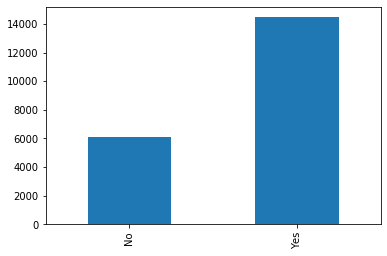

In [23]:
ward_value_counts = property_sales.in_rto_study.value_counts(sort = False).plot.bar()

As this feature is boolean in its nature from puerly technical perspective it is suitable to be used in the analysis. 

Please note that from purely domain-related standpoint, it does not seem to influence the property sales, but as the we are not enough property sales domain-versed, we would leave this feature during the clustering with the idea that if it is not important it would be ignored after the PCA step anyway.   

##### `ward`

In [24]:
property_sales[property_sales.ward.isna()].shape

(0, 24)

In [25]:
len(property_sales.ward.unique()) 

13

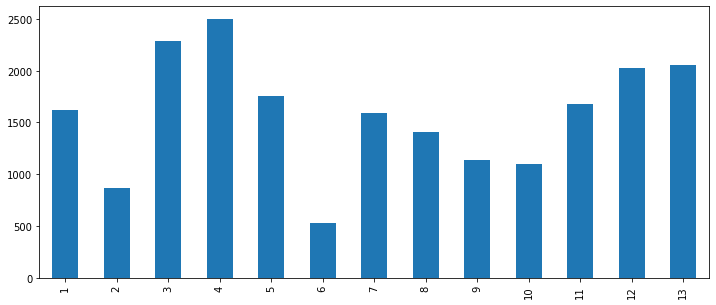

In [26]:
plt.figure(figsize=(12,5))
ward_value_counts = property_sales.ward.value_counts(sort = False).plot.bar()

This is a category variable with fairly small number of categories (just `13`), so we are going to leave it during the clustering. If it makes the model computation difficult or incorrect, then we will exclude it at a later step.

#### Processing Address Related Features

In the sections below we will review whether the address related features from the input dataset are suitable for the clustering analysis.

##### `address`

In [27]:
property_sales[property_sales.address.isna()].shape

(0, 24)

In [28]:
len(property_sales.address.unique())

20550

In [29]:
property_sales.address.unique()

array(['19 1ST ST S #B2005', '19 1ST ST S #B-608', '19 1ST ST S #B2708',
       ..., '5051 Lyndale AVE S', '5067 Lyndale AVE S',
       '5125 Lyndale AVE S'], dtype=object)

This feature seems to be a combination of `house_number`, `street_name`, `street_type` and post code features. As it is hard to be used for clustering purposes, it will be excluded from the follow-up analysis.

##### `house_number` and `house_number_2`

Reviewing `house_number` and `house_number_2` columns we could see that both columns are irrelevant to our study.

The available values for `house_number` are only about `16%`:

In [30]:
property_sales.house_number.unique()

array([  19,  110,  121, ..., 3203, 4757, 5067])

In [31]:
len(property_sales.house_number.unique())/len(property_sales)

0.1672992700729927

Similarly `house_number_2` contains values which do not seem relevant to our analysis:

In [32]:
property_sales.house_number_2.unique()

array(['NULL', ' 1/2', ' H', '-5415'], dtype=object)

As a conclusion, both features will not be included into the clustering analysis.

##### `street_name`

In [33]:
property_sales[property_sales.street_name.isna()].shape

(0, 24)

In [34]:
len(property_sales.street_name.unique())

354

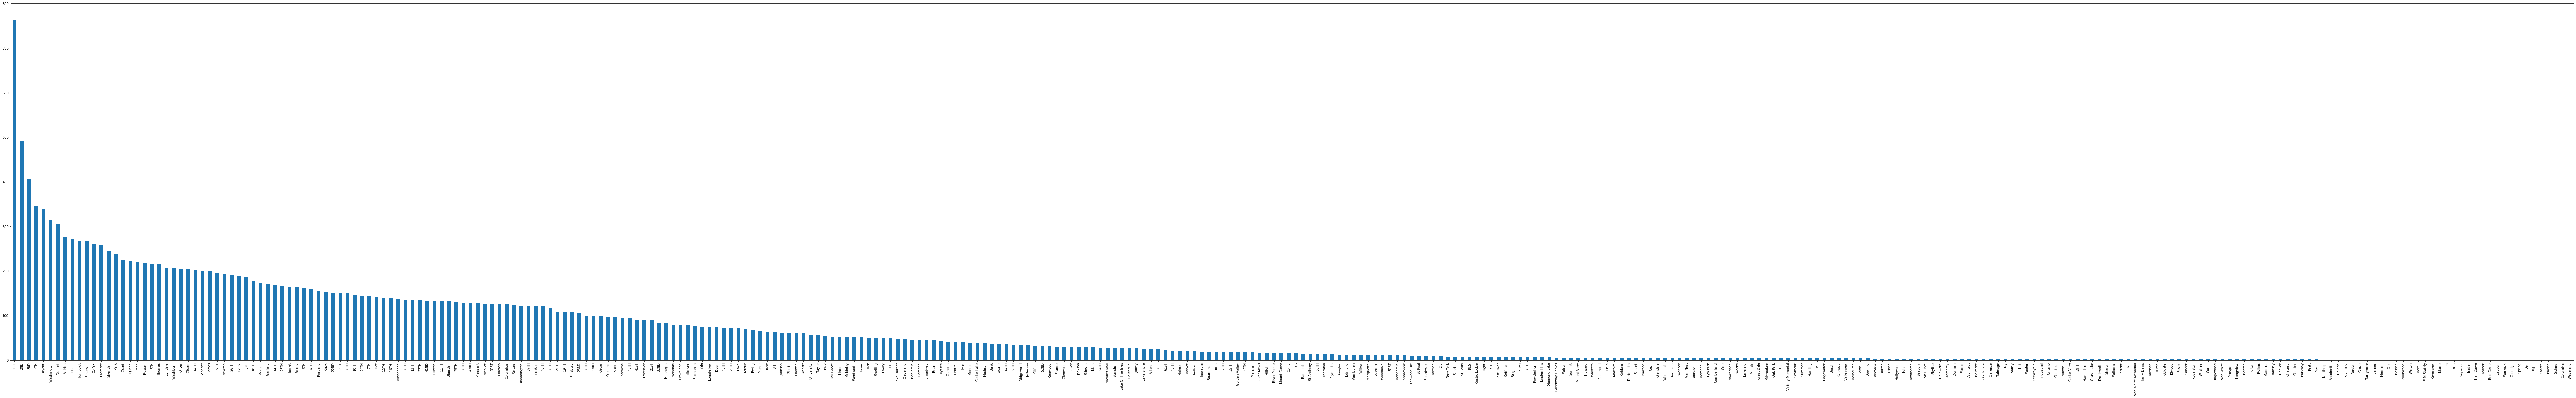

In [35]:
plt.figure(figsize=(140,20))
property_sales.street_name.value_counts(sort = True).plot.bar()

The initial idea during analysis of the input dataset was to preserve the `street_name` feature, as it seems that some streets are more popular than others, i.e. from domain point of view streets are important, but when we create indicator variables the number of dataset features is increasing several times, i.e. from `114` to `479`, which considering the small size of the dataset (`60906` before de-duplication and `20550` afterwards) is not a viable solution as it will decrease the precision of the clustering. 

That is why, `street_name` would be removed from the list of features to be used for clustering. When there is more input data (e.g. samples number larger than at least `100000`), then we could reconsider our decision and include `street_name` as anoter feature to our analysis.

##### `neighbourhood`

In [36]:
property_sales[property_sales.neighborhood.isna()].shape

(0, 24)

In [37]:
len( property_sales.neighborhood.unique())

87

In [38]:
 property_sales.neighborhood.value_counts(sort=False)

WINDOM PARK               282
MARSHALL TERRACE           70
MID CITY INDUSTRIAL AR     25
ERICSSON                  213
KING FIELD                425
                         ... 
HAWTHORNE                 355
WEBBER-CAMDEN             384
PROSPECT PK/E RIVER RD    169
FOLWELL                   453
LOWRY HILL                216
Name: neighborhood, Length: 87, dtype: int64

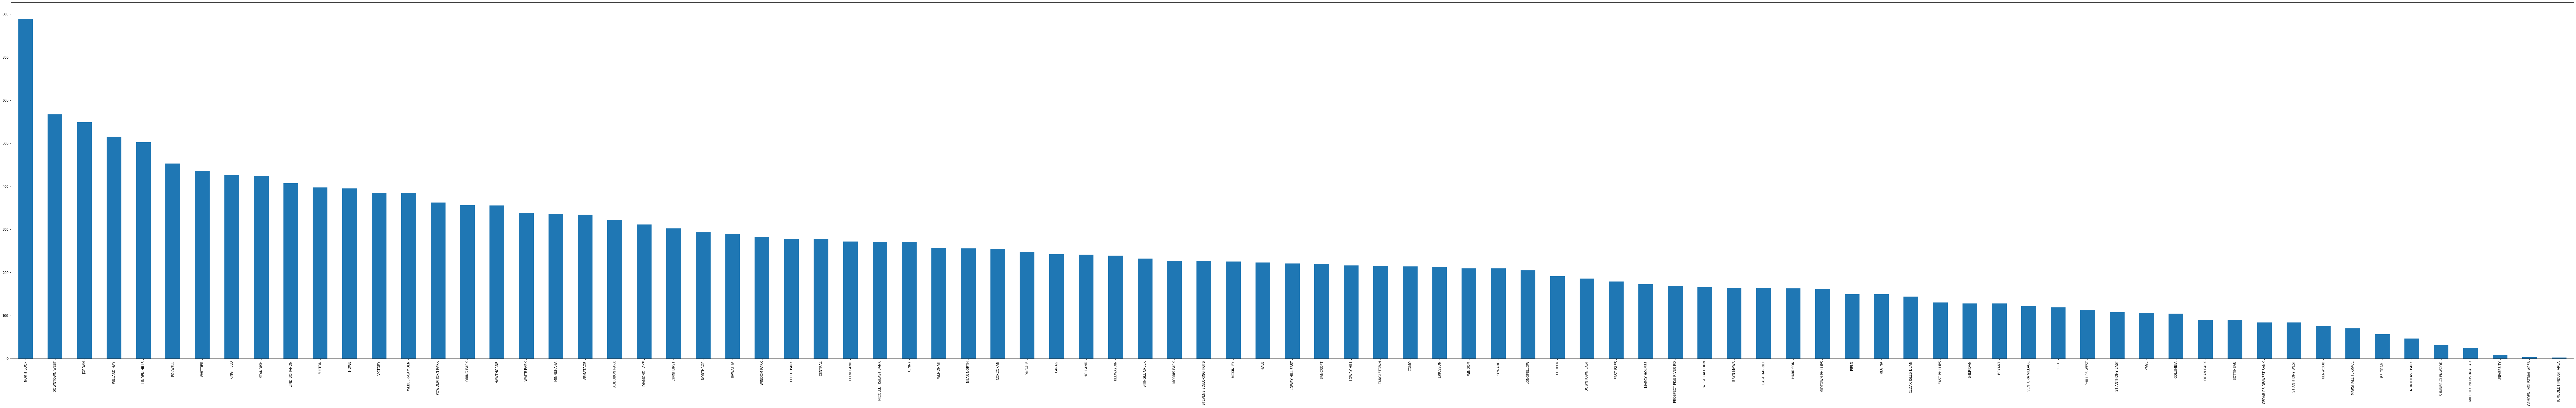

In [39]:
plt.figure(figsize=(140,20))
property_sales.neighborhood.value_counts(sort=True).plot.bar()

`neighbourhood` is a category variable and although it has fairly high number of unique values (which later on would result in high number of indicator variables), it is important for the clustering from domain point of view, so we will not remove that feature.

##### `prop_type`

In [40]:
property_sales[property_sales.prop_type.isna()].shape

(0, 24)

In [41]:
len(property_sales.prop_type.unique())

19

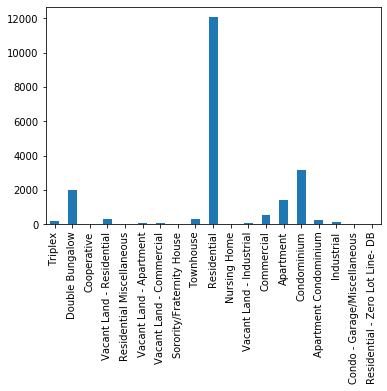

In [42]:
property_sales.prop_type.value_counts(sort=False).plot.bar()

Although the magnitude of teh residential properties sold is highly disproportionate to the rest of the property types on the market we will preserve this feauture as it seems important. 

##### `prefix_direction`

In [43]:
property_sales[property_sales.prefix_direction.isna()].shape

(0, 24)

In [44]:
len(property_sales.prefix_direction.unique())

2

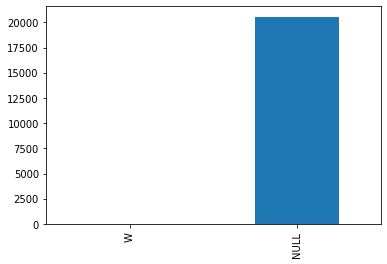

In [45]:
property_sales.prefix_direction.value_counts(sort=False).plot.bar()

Apparently, most of the values for this feature are missing, so it will not be taken into account for our analysis.

##### `street_type`

In [46]:
property_sales[property_sales.street_type.isna()].shape

(0, 24)

In [47]:
len(property_sales.street_type.unique())

13

In [48]:
property_sales.street_type.unique()

array(['ST', 'AVE', 'CT', 'PL', 'BLVD', 'RD', 'PKWY', 'DR', 'LN', 'TERR',
       'NULL', 'CIR', 'CV'], dtype=object)

In [49]:
property_sales[property_sales['street_type'] == 'NULL'].shape 

(72, 24)

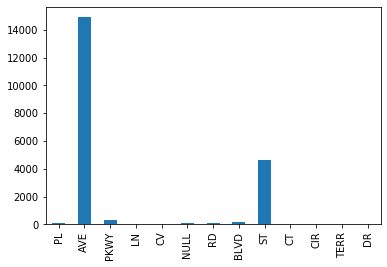

In [50]:
property_sales.street_type.value_counts(sort=False).plot.bar()

Although the `NULL` values are negligibly small, after the initial iterations of our analysis we came to the conclusion that the impact of this feature to the outcome of our clustering is minimal, therefore we are removing it for further use.

##### `suffix_direction`

In [51]:
property_sales.suffix_direction.unique()

array(['S', 'NE', 'N', 'SE', 'E', 'W', 'NULL'], dtype=object)

In [52]:
property_sales[property_sales['suffix_direction'] == 'NULL'].shape

(5334, 24)

In [53]:
len(property_sales[property_sales['suffix_direction'] == 'NULL'])/len(property_sales) # 5% of the data is NULL

0.2595620437956204

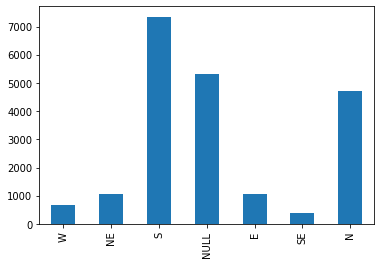

In [54]:
property_sales.suffix_direction.value_counts(sort=False).plot.bar()

The missing values for this categorisation variable are `26%`, which means that if we exclude these samples from the dataset, it would have too high (negative) impact on the clustering (as there would not be enough number of data samples but the number of features would be too high, i.e. due to the "curse of dimensionality" we could introduce too much noise in the output model). 

Also, on a later step probably the missing `suffix_direction` values could be deduced/populated based on the geo-related information. Also due to time restriction, this will be left as a future work. 

In the meantime, this column will be removed from the modeling process.

#### Processing Sale Date Related Features

##### `sale_date` and `sale_date_2`

It seems that `sale_date` and `sale_date_2` have identical values, hence we dismiss the second copy (`sale_date_2`) of the data:

In [55]:
property_sales[property_sales['sale_date'] != property_sales['sale_date_2']].shape

(0, 24)

We would like to check whether converting `sale_date` to a `datetime` type would be of any use for our analysis:

In [56]:
property_sales['sale_date'] = property_sales['sale_date'].apply(pd.to_datetime)

##### Exploring `year`, `month`, `day` features 

Creating three new properties from the date - `year`, `month` and `day`:

In [57]:
property_sales['year'] = property_sales.sale_date.dt.year

In [58]:
property_sales.year.unique()

array([2004, 2005, 2002, 2003])

(array([4476., 4795., 5310., 5969.]),
 array([2002.  , 2002.75, 2003.5 , 2004.25, 2005.  ]),
 <a list of 4 Patch objects>)

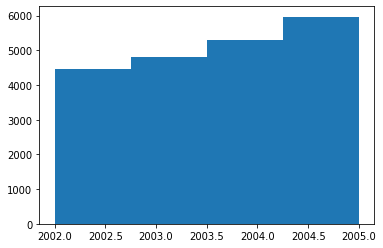

In [59]:
plt.hist(property_sales.year, bins = 4)

It does not look like the sales have major changes throughout the years, hence we would not create a new feature for year.

Creating a `month` feature for potential use:

In [60]:
property_sales['month'] = property_sales['sale_date'].dt.month

In [61]:
property_sales.month.unique()

array([12,  9,  3,  5, 10,  6,  1,  8, 11,  4,  7,  2])

(array([1245., 1208., 1558., 1652., 1984., 2023., 1889., 2143., 1960.,
        1787., 1587., 1514.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

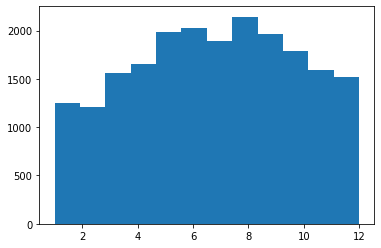

In [62]:
plt.hist(property_sales.month, bins = 12)

Creating a `day` feature for potential use during the clustering:

In [63]:
property_sales['day'] = property_sales['sale_date'].dt.day

(array([ 761.,  451.,  479.,  416.,  454.,  401.,  442.,  451.,  410.,
         534.,  405.,  512.,  484.,  614., 1040.,  613.,  596.,  601.,
         534.,  587.,  624.,  704.,  659.,  644.,  828.,  821.,  953.,
        1198., 1179., 1389.,  766.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

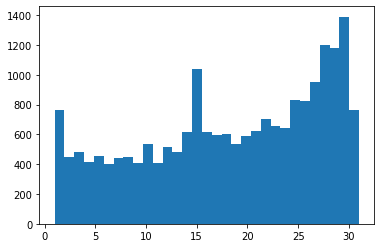

In [64]:
plt.hist(property_sales.day, bins=31)

It seems that `day` and `month` might be useful for the clustering, although there is high probability that they will introduce too many indicator variables, which might have an impact on the precision of the clustering (due to insufficient sample data). At first, we would exclude these features from the clustering.

It does not look like we will need `sale_date` and `year` properties, so we are going to remove them from the feature set as well.

#### Processing Sale Participants Related Features

It seems that the property market jargon in USA the seller of the property is called grantor and the person who pruchases the property - grantee.

##### `grantee`

In [65]:
property_sales.grantee.unique()

array(['Larry J Schmidt', 'Christian J Girtz', 'John P Breese', ...,
       'Eric A Thoerner', 'Daniel Whipp', 'Harald F Markley'],
      dtype=object)

In [66]:
property_sales[property_sales.grantee.isna()].shape

(0, 27)

In [67]:
len(property_sales.grantee.unique())/len(property_sales)

0.9151824817518248

It seems that `91%` of the grantees are different people, which means that the values in that column are virtually unique, hence we will exclude this column from the clustering analysis.

##### `grantor`

In [68]:
property_sales.grantor.unique()

array(['John M Parkman', 'Neil Kynnersley', 'Joan A Leong', ...,
       'Sara E Sternberger', 'Linda O Bergum', 'Philip B Mortenson'],
      dtype=object)

In [69]:
property_sales[property_sales.grantor.isna()].shape

(0, 27)

In [70]:
len(property_sales.grantor.unique())/len(property_sales)

0.8002433090024331

Similarly to the grantees, grantors seem to be `84%` unique, hence we will exclude this feature from the clustering as well.

#### Processing Sale Price Features

##### `gross_sale_price`

In [71]:
property_sales.gross_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 552000.])

In [72]:
property_sales[property_sales.gross_sale_price.isna()].shape

(0, 27)

In [73]:
min(property_sales.gross_sale_price)

0.0

In [74]:
property_sales.gross_sale_price = property_sales.gross_sale_price.fillna(-1)

In [75]:
len(property_sales[property_sales.gross_sale_price == 0].gross_sale_price)/len(property_sales)

0.00043795620437956203

In [76]:
property_sales.gross_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 552000.])

In [77]:
property_sales.gross_sale_price.value_counts(sort=True) #.plot.bar()

175000.0    189
200000.0    180
150000.0    169
165000.0    168
180000.0    163
           ... 
321450.0      1
185300.0      1
117225.0      1
415929.0      1
218649.0      1
Name: gross_sale_price, Length: 5178, dtype: int64

The number of unavailable values for `gross_sale_price` is negligible (~`0.5%`), therefore filled in the missing values with `-1` in order to rectify the validity of the values in the column. It is true that we introduce bias in that way, but for now we consider it acceptable.

##### `adjusted_sale_price`

In [78]:
property_sales.adjusted_sale_price.unique()

array([163200., 179900., 260000., ..., 208120., 364900., 537303.])

In [79]:
property_sales[property_sales.adjusted_sale_price.isna()].shape

(2, 27)

In [80]:
len(property_sales[property_sales.adjusted_sale_price < 0])

9

In [81]:
property_sales.adjusted_sale_price = property_sales.adjusted_sale_price.fillna(-1)

In [82]:
property_sales.adjusted_sale_price.value_counts(sort=False)#.plot.bar()

 0.0         10
 131072.0     1
-1.0          2
 1.0          2
 180225.0     1
             ..
 983000.0     1
 98300.0      1
 294900.0     6
 409594.0     1
 94207.0      1
Name: adjusted_sale_price, Length: 6059, dtype: int64

In [83]:
property_sales[property_sales.adjusted_sale_price < 0].head()

object_id       crv              pin  sale_date in_rto_study  \
1430        6431  882975.0  "2202824120129" 2004-12-29          Yes   
5345       14346  858080.0   "602823240193" 2004-05-14           No   
10076       1077  894638.0   "202824430124" 2005-06-10          Yes   
11047      15048  882280.0   "102824340010" 2004-12-31          Yes   
13012      12013  885393.0  "1202824110121" 2004-12-27           No   

          neighborhood  ward    prop_type          address  house_number  \
1430            WINDOM    11  Residential   5520 1ST AVE S          5520   
5345        LONGFELLOW     2  Residential  3300 36TH AVE S          3300   
10076  POWDERHORN PARK     8  Residential  3733 12TH AVE S          3733   
11047         STANDISH    12  Residential   2318 38TH ST E          2318   
13012         STANDISH    12  Residential  3824 30TH AVE S          3824   

      house_number_2 prefix_direction street_name street_type  \
1430            NULL             NULL         1ST         AVE   
5345            NULL             NULL        36TH         AVE   
10076           NULL             NULL        12TH         AVE   
11047           NULL             NULL        38TH          ST   
13012           NULL             NULL        30TH         AVE   

      suffix_direction                               grantee  \
1430                 S                       Aaron J Harkins   
5345                 S  Chicago Investment Group Corporation   
10076                S                         Adam C Thorne   
11047                E                        Dena M Sanford   
13012                S                  William S Mcelligott   

                                                 grantor  adjusted_sale_price  \
1430                                     Wendy M Brekken              -4900.0   
5345                                        Shigeo Hotta             -15100.0   
10076                                     Susan M Schmid              -4000.0   
11047                                   Ryvonne M Dennis              -3900.0   
13012  Western United Life Assurance Co C / O Ocwen F...            -102000.0   

       gross_sale_price          sale_date_2 downpayment              x  \
1430           270000.0  2004-12-29T00:00:00        NULL  527515.075938   
5345            45000.0  2004-05-14T00:00:00         900  542098.359766   
10076          208700.0  2005-06-10T00:00:00       16870  532704.134265   
11047          138000.0  2004-12-31T00:00:00        NULL  537662.758305   
13012           48000.0  2004-12-27T00:00:00        NULL  539728.409111   

                   y                    geometry  year  month  day  
1430   140708.623010  POINT (-93.27715 44.90271)  2004     12   29  
5345   155446.645034  POINT (-93.22076 44.94307)  2004      5   14  
10076  152379.565737  POINT (-93.25706 44.93470)  2005      6   10  
11047  152263.296399  POINT (-93.23791 44.93436)  2004     12   31  
13012  151875.106682  POINT (-93.22994 44.93328)  2004     12   27

The number of unavailable values for `adjusted_sale_price` is negligible (~`0.01%`), therefore filled in the missing values with `-1` in order to rectify the validity of the values in the column but there are a few values which are negative, which might mean that we cannot rely on this feature for the clustering phase, therefore we will remove this feature from the analysis.

##### `downpayment`

In [84]:
property_sales.downpayment.unique()

array(['32650', '5400', '260000', ..., '26600', '545000', '52250'],
      dtype=object)

In [85]:
len(property_sales[property_sales.downpayment == 'NULL'])/len(property_sales) # 5% of the data is NULL

0.6149391727493917

As `61%` of the `downpayment` values are missing, we remove this feature.

#### Processing Geography Related Features

##### `x` and `y`

As per dataset features description:

> _X ... and... Y ... coordinates are expressed in the NAD 83 Hennepin County HARN coordinate system (WKID: 103734)_

we are not interested at the moment in these features, so we are going to remove them.

##### `geometry`, `lat` and `lon`

In [86]:
property_sales[property_sales.geometry.isna()].shape

(0, 27)

As `geometry` is of type `Point`, it does seem to be an unhashable type, which would become an obstacle later on during the creation of indicator variables (dummies). That is why we create two numeric columns `lat` and `lon` respectively, which would represent lattitude and longitude:

In [87]:
property_sales['lat'] = property_sales.geometry.x

In [88]:
property_sales['lon'] = property_sales.geometry.y

###### Properties Plotted on a Geo Map

We do a quick check whether the usage of the new latitude and longitude features are useful and whether we could gain some insights from plotting the properties on an actual geographical map

In [89]:
# import warnings
# warnings.filterwarnings('ignore')

# figure = plt.figure(figsize=(15,15))
# current_axis = figure.add_subplot(111)

# map = Basemap(llcrnrlon=-93.356022, llcrnrlat=44.874466, urcrnrlon=-93.174347, urcrnrlat=45.063683, \
#               resolution='i', lat_0 = 46.392410, lon_0 = -94.636230, width=100, height=200)
# map.fillcontinents(color = "white", lake_color = "#7777ff", ax = current_axis)

# earth_x, earth_y = map(property_sales.lat.tolist(), property_sales.lon.tolist())

# map.scatter(earth_x, earth_y, color="darkgreen", s = 1, zorder=10)
# map.drawmapboundary(fill_color = "#7777ff")
# map.drawstates()
# map.drawcountries()
# map.drawrivers()

# plt.xlabel("Latitude")
# plt.ylabel("Longitude")
# plt.title("Properties Sold in Minnessota, 2002-2005")

# plt.show()

At first sight, visually screening the property sales plotted on a geo-map, we cannot obtain any insight on whether geo-defined clustering of the data is in place or not.

### Removing Redundant Features 

In [90]:
property_sales.shape

(20550, 29)

Following the results from the initial data analysis, we are to remove the features which do not appear useful for our clustering analysis:
* `object_id`
* `crv`
* `pin`
* `address`
* `house_number`
* `house_number_2`
* `prefix_direction`
* `street_name`
* `street_type`
* `suffix_direction`
* `sale_date_2`
* `sale_date`
* `year`
* `grantee`
* `grantor`
* `adjusted_sale_price`
* `downpayment`
* `x`
* `y`
* `geometry`

In [91]:
columns_for_removal = ['object_id', 'crv', 'pin', 'address', 'house_number', 'house_number_2', 'prefix_direction', \
                       'street_name', 'street_type', 'suffix_direction', 'sale_date_2', 'sale_date', 'year', 'month', \
                       'day', 'grantee', 'grantor', 'downpayment', 'x', 'y', 'geometry', 'adjusted_sale_price']

In [92]:
property_sales_data = property_sales.drop(columns=columns_for_removal, axis=1)

The set of initial features we end up with for clustering is as follows:

In [93]:
property_sales_data.head()

in_rto_study   neighborhood  ward    prop_type  gross_sale_price        lat  \
0          Yes  DOWNTOWN WEST     3  Condominium          163200.0 -93.266497   
3          Yes  DOWNTOWN WEST     3  Condominium          179900.0 -93.266497   
4          Yes  DOWNTOWN WEST     3  Condominium          260000.0 -93.266497   
5           No  DOWNTOWN WEST     3   Commercial           16500.0 -93.266497   
6          Yes  DOWNTOWN WEST     3  Condominium          230000.0 -93.266497   

         lon  
0  44.982613  
3  44.982613  
4  44.982613  
5  44.982613  
6  44.982613

In [94]:
property_sales_data.shape

(20550, 7)

### Creating Indicator Variables/Features (Dummies)

As some of the features are with category nature, e.g. `prop_type`, `ward`, `neighborhood`, based on their values we need to create indicator variables, so that we have all our features be of numerical types, thus easy to process later on.

In [95]:
property_sales_data_dummies = pd.get_dummies(property_sales_data)

In [96]:
property_sales_data_dummies.shape

(20550, 112)

In [97]:
property_sales_data_dummies.describe().T

count           mean           std  \
ward                                 20550.0       7.069586  3.907593e+00   
gross_sale_price                     20550.0  318302.043406  2.787592e+06   
lat                                  20550.0     -93.271668  3.138176e-02   
lon                                  20550.0      44.963505  4.234711e-02   
in_rto_study_No                      20550.0       0.296545  4.567452e-01   
...                                      ...            ...           ...   
prop_type_Triplex                    20550.0       0.008856  9.369332e-02   
prop_type_Vacant Land - Apartment    20550.0       0.003358  5.784940e-02   
prop_type_Vacant Land - Commercial   20550.0       0.004185  6.455698e-02   
prop_type_Vacant Land - Industrial   20550.0       0.001995  4.462343e-02   
prop_type_Vacant Land - Residential  20550.0       0.015815  1.247627e-01   

                                           min            25%            50%  \
ward                                  1.000000       4.000000       7.000000   
gross_sale_price                      0.000000  150362.500000  199900.000000   
lat                                 -93.328812     -93.297212     -93.273372   
lon                                  44.890816      44.927711      44.960364   
in_rto_study_No                       0.000000       0.000000       0.000000   
...                                        ...            ...            ...   
prop_type_Triplex                     0.000000       0.000000       0.000000   
prop_type_Vacant Land - Apartment     0.000000       0.000000       0.000000   
prop_type_Vacant Land - Commercial    0.000000       0.000000       0.000000   
prop_type_Vacant Land - Industrial    0.000000       0.000000       0.000000   
prop_type_Vacant Land - Residential   0.000000       0.000000       0.000000   

                                               75%           max  
ward                                     11.000000  1.300000e+01  
gross_sale_price                     275000.000000  2.245000e+08  
lat                                     -93.248958 -9.320141e+01  
lon                                      44.999204  4.505106e+01  
in_rto_study_No                           1.000000  1.000000e+00  
...                                            ...           ...  
prop_type_Triplex                         0.000000  1.000000e+00  
prop_type_Vacant Land - Apartment         0.000000  1.000000e+00  
prop_type_Vacant Land - Commercial        0.000000  1.000000e+00  
prop_type_Vacant Land - Industrial        0.000000  1.000000e+00  
prop_type_Vacant Land - Residential       0.000000  1.000000e+00  

[112 rows x 8 columns]

We observe tenfold increase of the number of features, but the number is not too high. Also during the PCA step of the data pre-processing will help us discard the influence of the insignificant features for our clustering.

### Scaling Features

As the values for the various feature values vary highly, we would like to put them in the same range so that our clustering analysis does not get skewed by the various scales of the feature. For the purpose we will use `MinMaxScaler` which will place all values in the `[0,1]` range.

In [98]:
scaler = MinMaxScaler()

In [99]:
scaler.fit(property_sales_data_dummies)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [100]:
property_sales_data_dummies_scaled = scaler.transform(property_sales_data_dummies)

### Principal Component Analysis (PCA)

Having too many features (i.e. high dimensionality), we cannot distinguish which are important ones for our analysis and which not, that is why we use Principal Component Analysis approach for linear dimensionality reduction to project it to a lower dimensional space.

In [101]:
pca = PCA().fit(property_sales_data_dummies_scaled)

In [102]:
property_sales_data_dummies_scaled_transformed = pca.transform(property_sales_data_dummies_scaled)

We need to look into which of the variance ratios are highest in order to find new attributes, which could represent the data in the new dimensional space.

In [103]:
pca.explained_variance_ratio_

array([2.27967447e-01, 1.04895007e-01, 7.51456606e-02, 5.61264558e-02,
       3.52280761e-02, 3.23316840e-02, 1.52494145e-02, 1.42942816e-02,
       1.16726192e-02, 1.14835455e-02, 1.08570142e-02, 1.03485196e-02,
       1.02254468e-02, 9.54146966e-03, 9.27293581e-03, 9.03280563e-03,
       8.89131313e-03, 8.79766441e-03, 8.37075972e-03, 8.28265838e-03,
       8.14225944e-03, 7.74784021e-03, 7.63954735e-03, 7.51904786e-03,
       7.38044897e-03, 7.16129965e-03, 7.00139870e-03, 6.91896547e-03,
       6.71993879e-03, 6.65690711e-03, 6.50563644e-03, 6.33823910e-03,
       6.23462036e-03, 6.12771686e-03, 6.03221207e-03, 5.93988864e-03,
       5.84634748e-03, 5.67041739e-03, 5.60645297e-03, 5.50657233e-03,
       5.47942232e-03, 5.37040400e-03, 5.31409581e-03, 5.29903214e-03,
       5.18900160e-03, 5.04658548e-03, 5.01080714e-03, 4.98355528e-03,
       4.91421520e-03, 4.88462474e-03, 4.78216554e-03, 4.76846784e-03,
       4.71537458e-03, 4.67415371e-03, 4.59677690e-03, 4.58532113e-03,
      

We observe that the first two ratios are highest, that is why we are going to limit our reduced features to them only. 

Please note that both options with smaller and higher number of PCA-ed features were explored, but the optimal results are achieved with only two of them. That is why we are reducing the PCA-transformed data set to just two parameters:

In [104]:
property_sales_data_dummies_scaled_transformed_reduced = property_sales_data_dummies_scaled_transformed[:, :2]

In [105]:
property_sales_data_dummies_scaled_transformed_reduced.shape

(20550, 2)

This is the dataset which we would use for clustering.

## 4. Finding Optimal Number of Clusters

In the following sections we will try to cluster the data using several clustering algorithms in order to find the most optimal clustering, thus finding the most optimal internal structure of the dataset. The algorithms used are the following: `KMeans++ Clustering`, `Agglomerative Clustering` and `Density Based Clustering Analysis (DBSCAN)`.

Before jumping to the actual analysis we will define some auxilliary functions which will help us visualise and work with the clustered data

### Auxilliary Functions for Cluster and Map Drawing

In [106]:
def plot_clusters(data, cluster_ids, title):
    """Plots clustered data in 2D format. 

    Parameters:
    data (int): 2D data which will be scattered
    cluster_ids: an array of cluster ids
    title: Plot title
   """
    plt.figure(figsize = (12,10))
    plt.scatter(data[:, 0], data[:, 1], c = cluster_ids)
    plt.title(title)
    plt.show()

In [107]:
# Based on: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def plot_kmeans_cluster_silhouette_profiles(data, clusters, clusterer):

    X = data
    cluster_labels = clusters
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    n_clusters = len(centers)

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])



    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [108]:
def plot_dendrogram(agglomerative_linkage, title):
    plt.figure(figsize = (12,10))
    dendrogram(agglomerative_linkage, leaf_rotation=0, orientation='right')
    
    ax = plt.gca()
    bounds = ax.get_ybound()
    ax.plot([1.1,1.1],bounds,'--', c='k', )
    plt.title(title)
    plt.show()

In [109]:
def create_dbscan_diagram_title(dbscan_cluster_number, dbscan_eps, dbscan_min_samples):
    return "Density Based (DBSCAN) Clusters: Clusters {}, for eps={}, min_samples={}"\
                .format(dbscan_cluster_number, dbscan_eps, dbscan_min_samples)

### Finding Right Number of Clusters 

In the next sub-sections we will use several approaches to find the most optimal number of clusters for the provided dataset.

#### Plotting Clustered Data

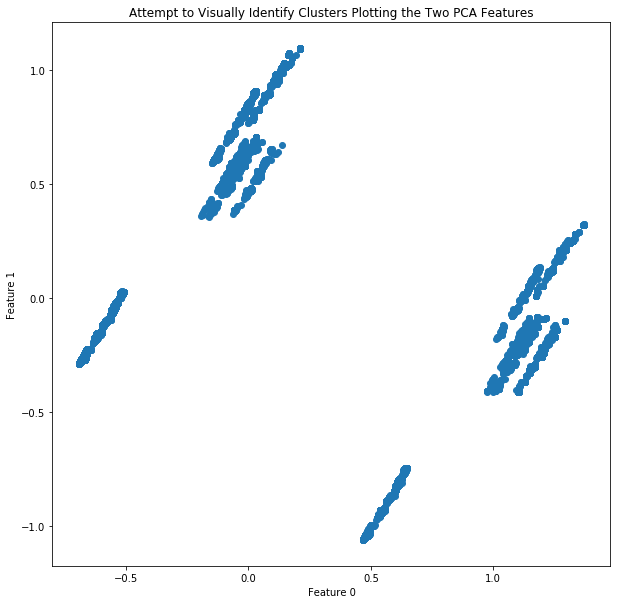

In [110]:
plt.figure(figsize = (10,10))
plt.scatter(property_sales_data_dummies_scaled_transformed_reduced[:, 0], 
            property_sales_data_dummies_scaled_transformed_reduced[:, 1])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Attempt to Visually Identify Clusters Plotting the Two PCA Features")
plt.show()

Although we could visually identify `4` well separated clusters, we will need to use more quantative approaches to prove that this is the most optimal number of clusters which exist for the properties sales dataset.

#### KMeans++ Clustering: Elbow Method

KMeans++ clustering algorithm expects number of clusters to be provided upfront. 

In order to select the most optimal number of clusters which properties sales dataset could be organised into, we will first calculate cluster intertias for the various configuration in terms of numbers of clusters and then apply the Elbow Method to define the most optimal clusters configuration (if the intertias/elbow function is good enough to alow it).

In [111]:
inertias = []
for i in range(1, 11):
    km = KMeans(n_clusters = i)
    km.fit(property_sales_data_dummies_scaled_transformed_reduced)
    inertias.append(km.inertia_)

The **Elbow Method** is is a heuristic method of interpretation and validation the consistency within clusters analysis which is designed to help finding the optimal number of clusters to which a dataset could be split.

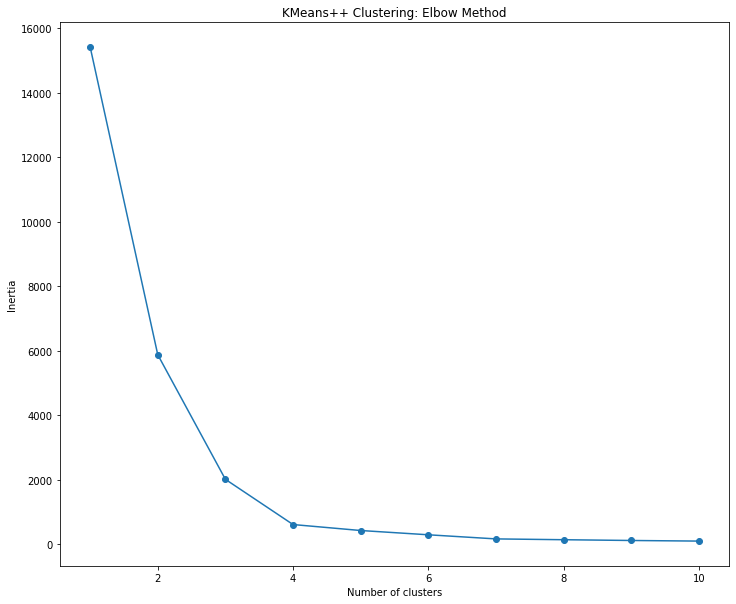

In [112]:
plt.figure(figsize = (12,10))
plt.plot(range(1, 11), inertias, marker = "o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("KMeans++ Clustering: Elbow Method")
plt.show()

As we could see the shape of the graph resembles elbow, which would mean that our data is well separated and allows for this method to be used. 

We could identify **`4`** as **the optimal number of clusters** as on the left hand side of the "point `4`" the inertias function decreases quicker than on the right side of the point, which means that increasing the number of clusters to more than 4, we would unnecessarily break the data to smaller clusters, without actually gaining any benefit. In fact, the distances between the clusters will not be that big and we ultimately will create unnecessarily high number of cluster.


As this method is often ambiguous and not very reliable, despite its good indication in our case, to confirm/disprove its output we will apply a couple of more approaches for determining the optimal number of clusters for our dataset, namely the Silhouette method for KMeans++ Clustering and Dendrogram Diagram for Agglomerative Clustering. 

#### KMeans++ Clustering: Cluster Silhouette Profies Method 

Another approach which could be used for finding the optimal number of clusters for a given dataset using the KMeans++ Clustering approach is the Silhouette Profiles, where such number of clusters is sought for which the distances of the points in the clusters to the centroid of the cluster are fairly equal, as well as the size of the clusters is ideally the same.

We will analyse the silhouette profiles of the various number of clusters in order to prove that `4` seems to be the best choice.

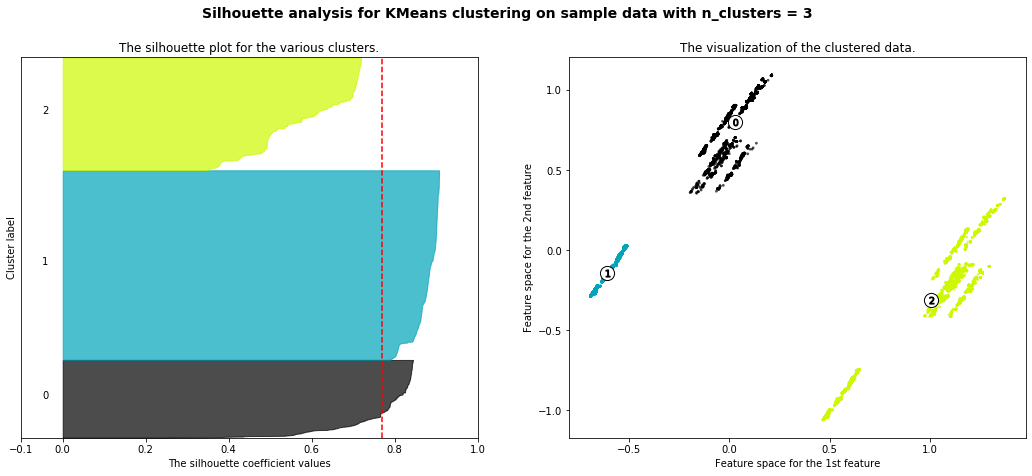

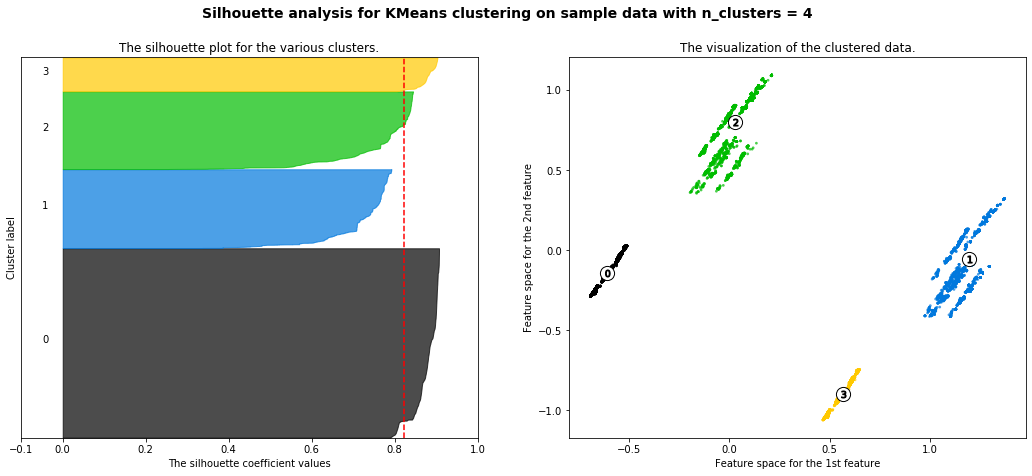

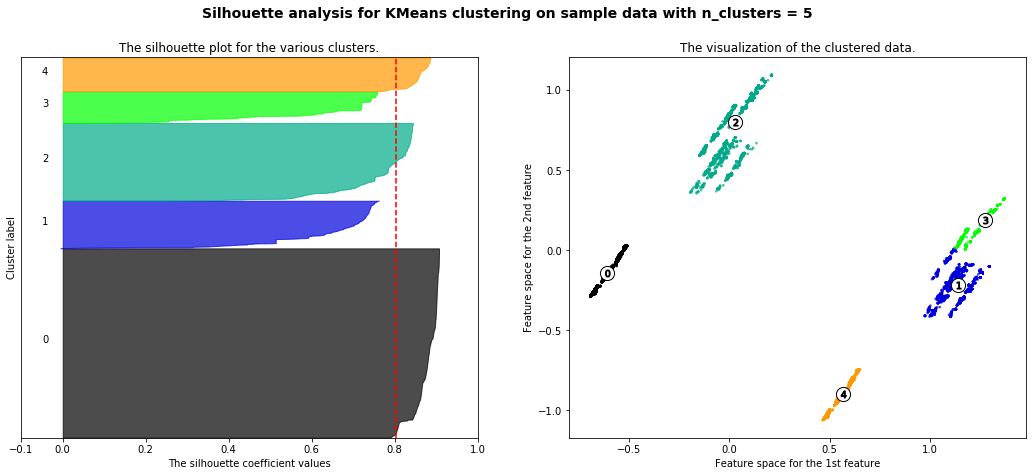

In [113]:
for number_of_clusters in [3, 4, 5]:
    kmeans_clusterer = KMeans(n_clusters = number_of_clusters)
    kmeans_clusterer.fit(property_sales_data_dummies_scaled_transformed_reduced)
    kmeans_clusters = kmeans_clusterer.predict(property_sales_data_dummies_scaled_transformed_reduced)
    plot_kmeans_cluster_silhouette_profiles(property_sales_data_dummies_scaled_transformed_reduced, \
                                        kmeans_clusters, kmeans_clusterer)

We could see that the most optimal data distribution of the data in clusters is when the number of clusters is `4`. In the case of `3` and `5` the clusters are not well shaped in the sense that there are points in the cluster which are closer to the centroids than others. In the case of `4` clusters, although the size of the clusters is not the same, the centroids are in a relatively equal distance from each point in the cluster.

We should note that KMeans++ works well but only if the data is well organised in clearly separated clusters. In our dataset it seems that we have well defined clusters which do not overlap which would mean that we could be fairly confident in using KMeans++ as a clustering approach.

#### Agglomerative Clustering: Dendrogram Diagram Method

Another way of assessing the most optimal number of clusters for a dataset is to use the agglomerative clustering approach and more specifically to use its **dendrogram** which similarly to the Elbow Method is based on the interias of the clusters. This approach is used to find out what is the number of clusters based on the larger distances between the points on the dendrogram.

We will use the default implementation of agglomerative linkage (with two clusters) provided by `scipy` to plot the dendrogram:

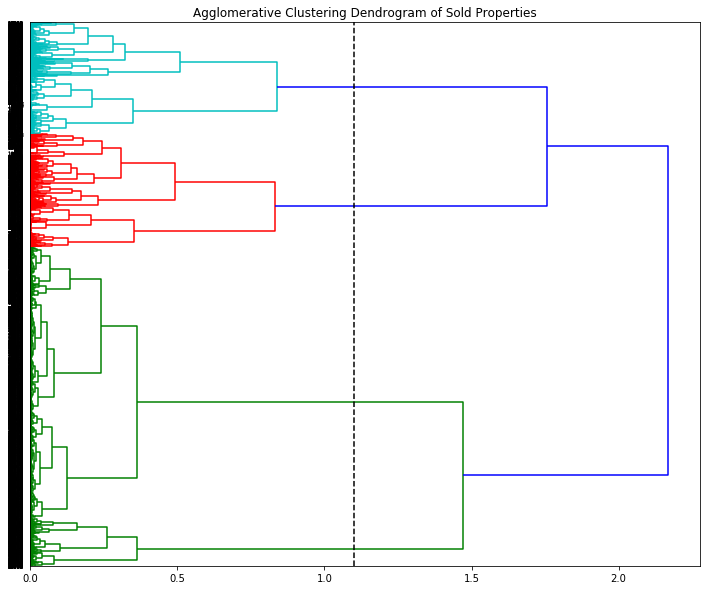

In [114]:
default_agglomerative_linkage = linkage(property_sales_data_dummies_scaled_transformed_reduced, \
                                    method = "complete", metric = "euclidean")

plot_dendrogram(default_agglomerative_linkage, "Agglomerative Clustering Dendrogram of Sold Properties")

Another approach of drawing the dendrogram of the property sales dataset is to use `seaborn` out-of-the-box functionality:

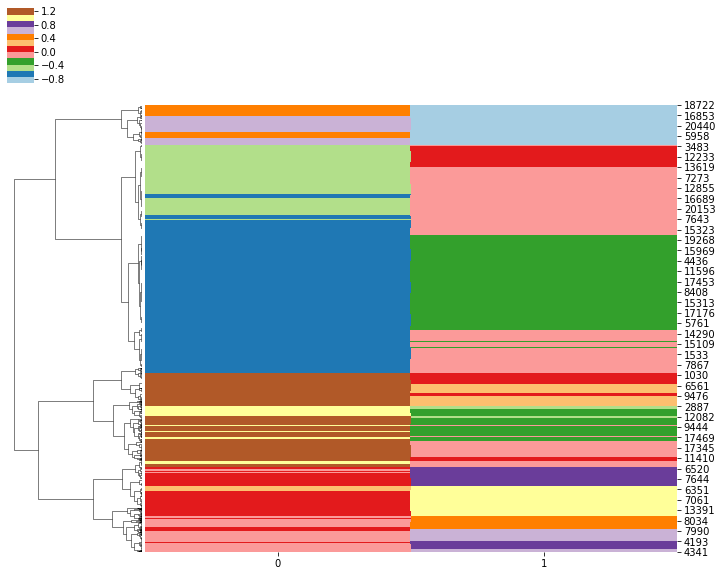

In [115]:
g = sns.clustermap(property_sales_data_dummies_scaled_transformed_reduced, \
                   method="complete", col_cluster=False,\
                   cmap="Paired", robust = True, figsize=(12, 10))

In both cases we could see that the longest distances between clusters are achieved for cluster distances between `0.8` and `1.5`. If we draw a line perpendicular to the clustering lines, the number of intersection points gives us the optimal number of clusters the dataset could be split when using agglomerative clustering, which is again `4`.

As shortly would be shown, the dataset has well shaped clusters, so all clustering algorithms used identify the same clusters.

#### DBSAN Clustering: Visual Method

Unfortunately Density Based Spatial Clustering for Applications with Noise (DBSCAN) does not have any specific method for finding the number of clusters, so we will generate several clustering options changing the radius $\epsilon$ of the vicinity and the number of noise points in order to visually identify the best number of clusters.

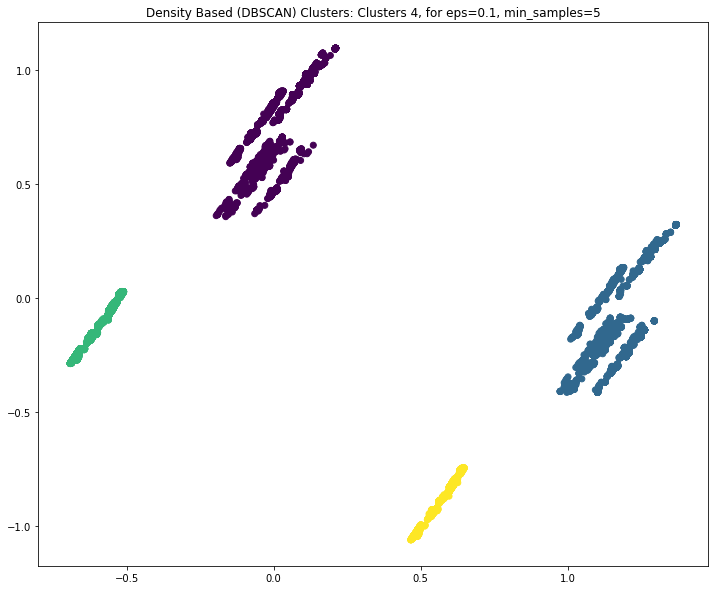

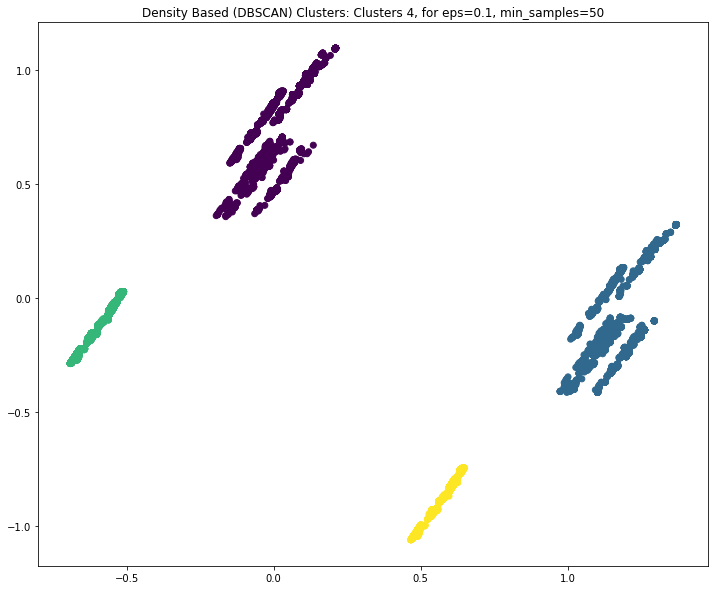

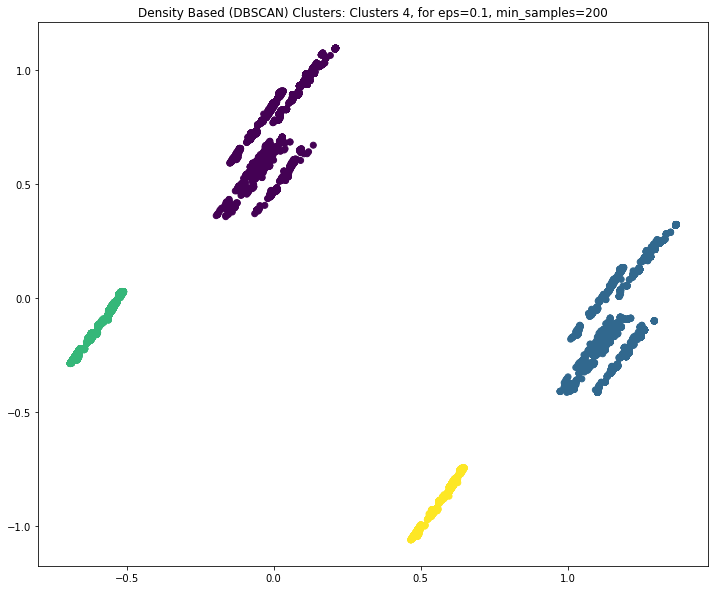

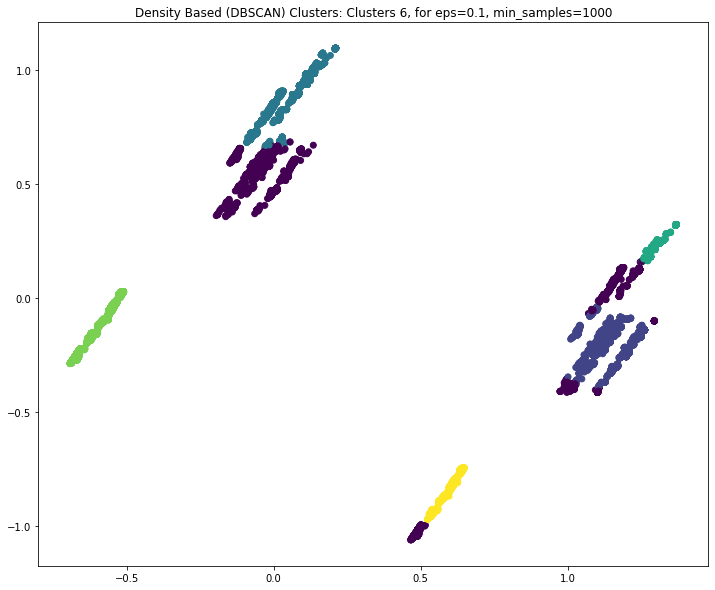

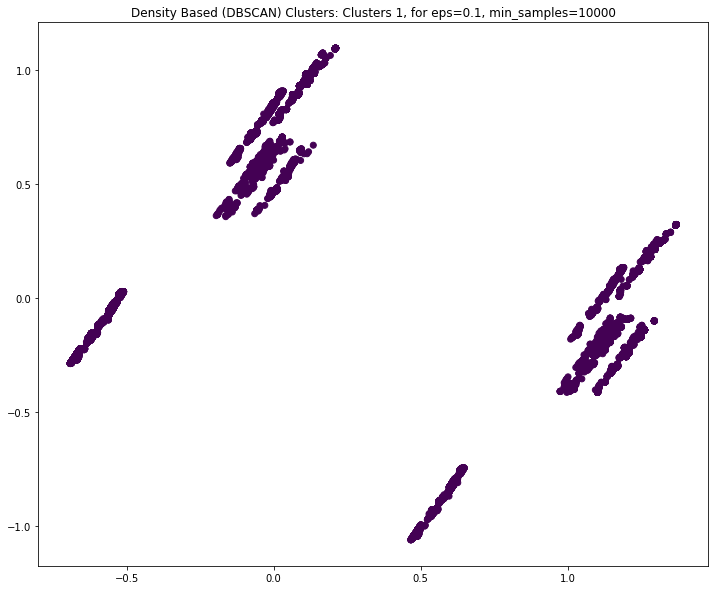

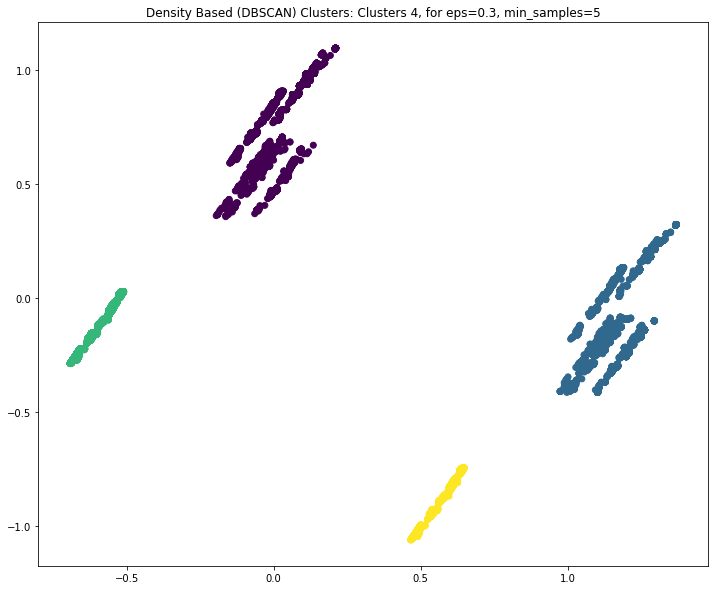

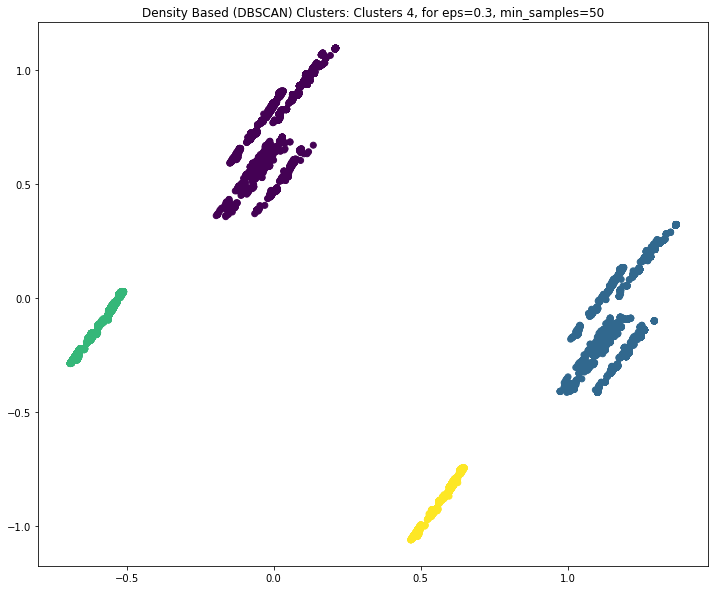

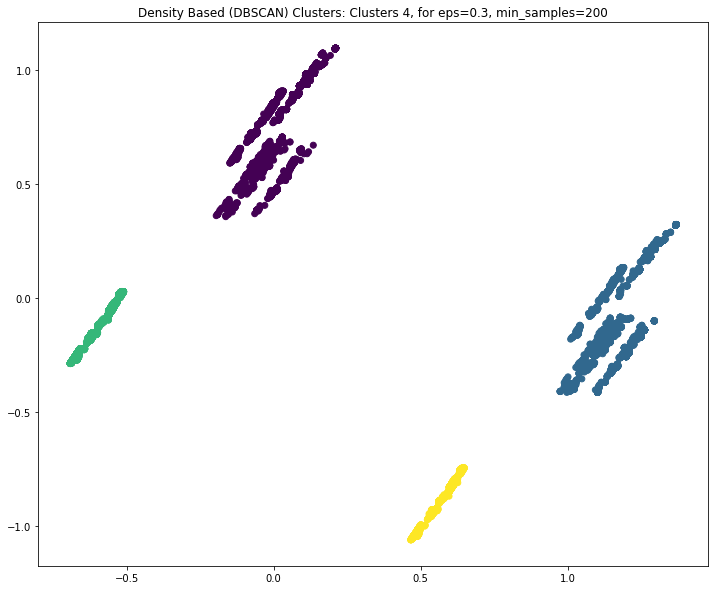

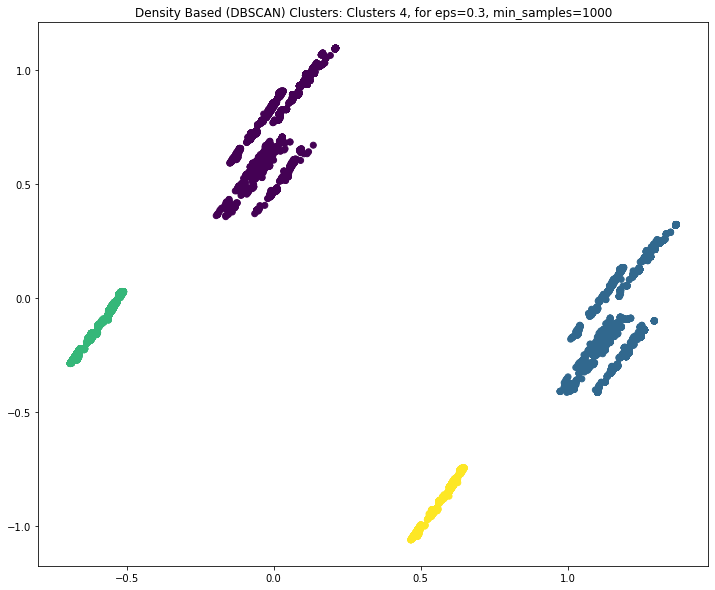

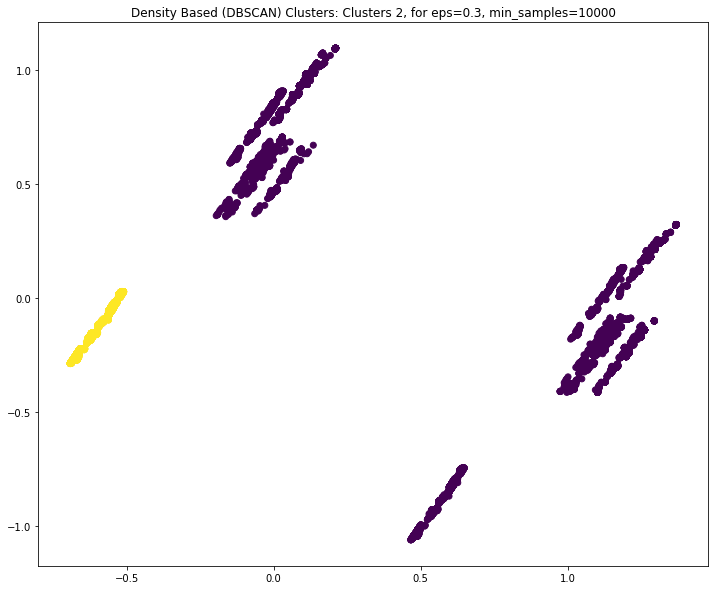

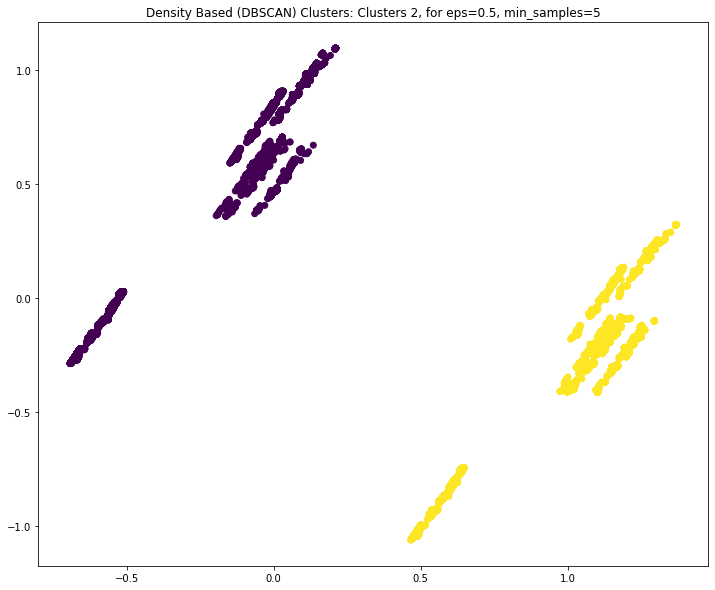

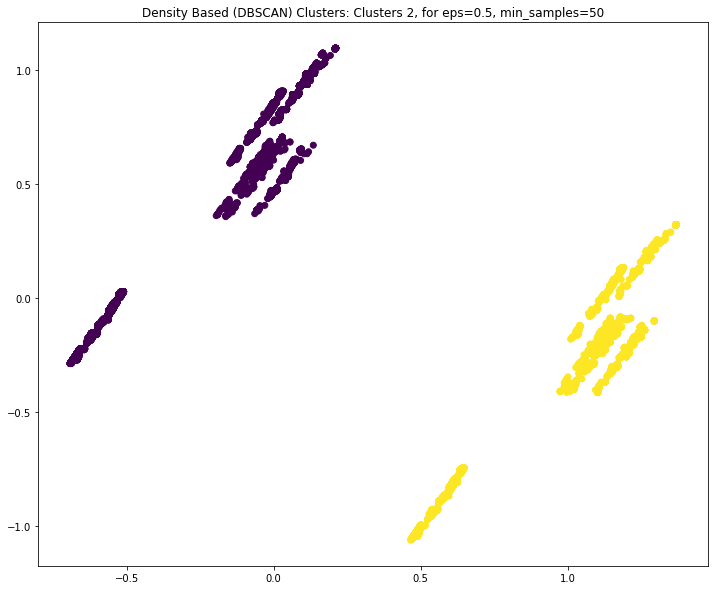

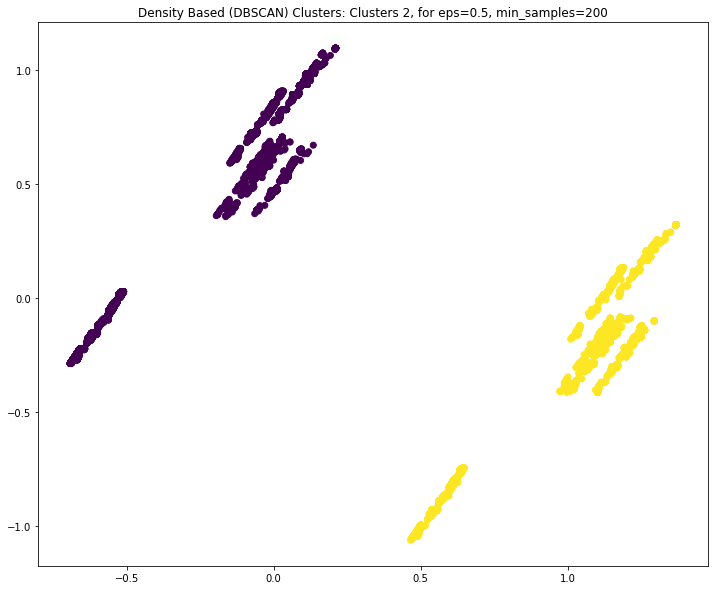

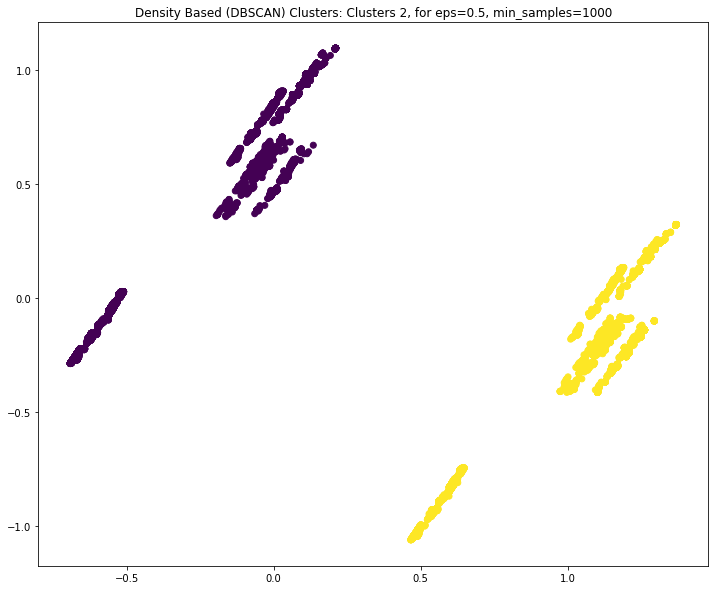

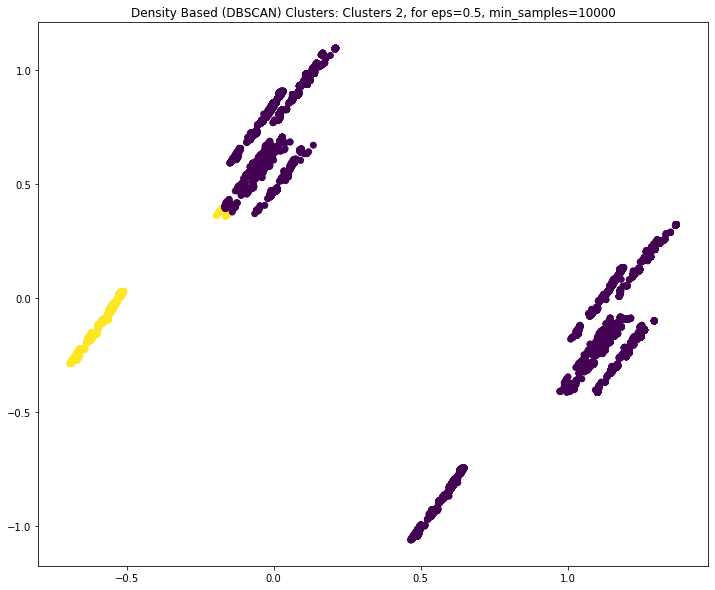

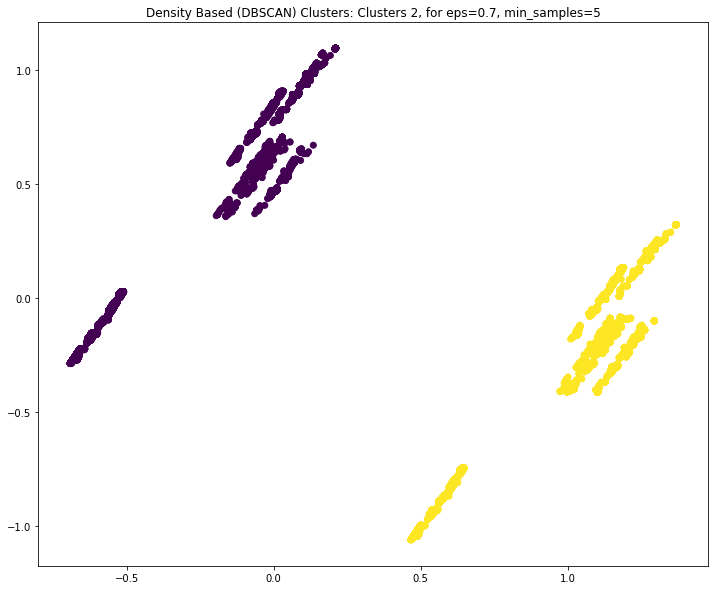

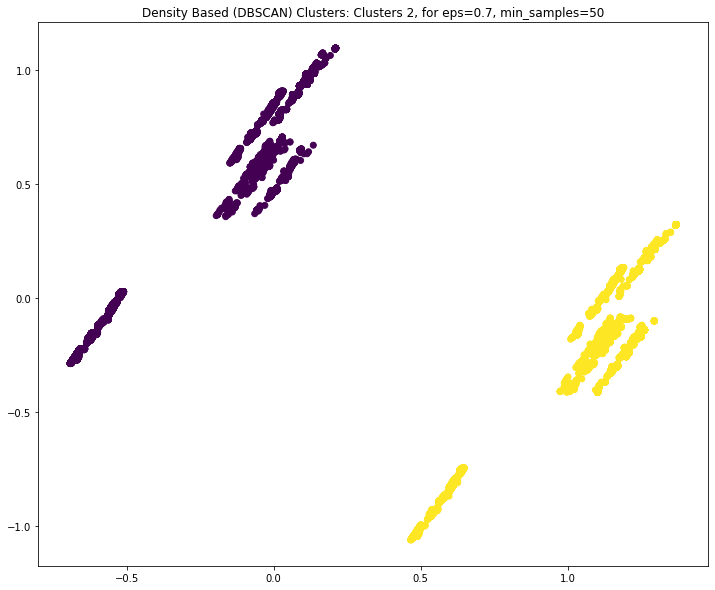

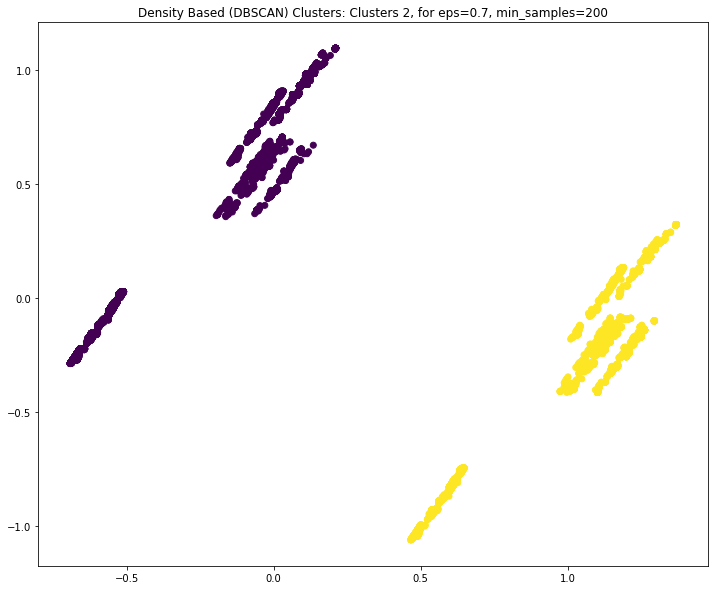

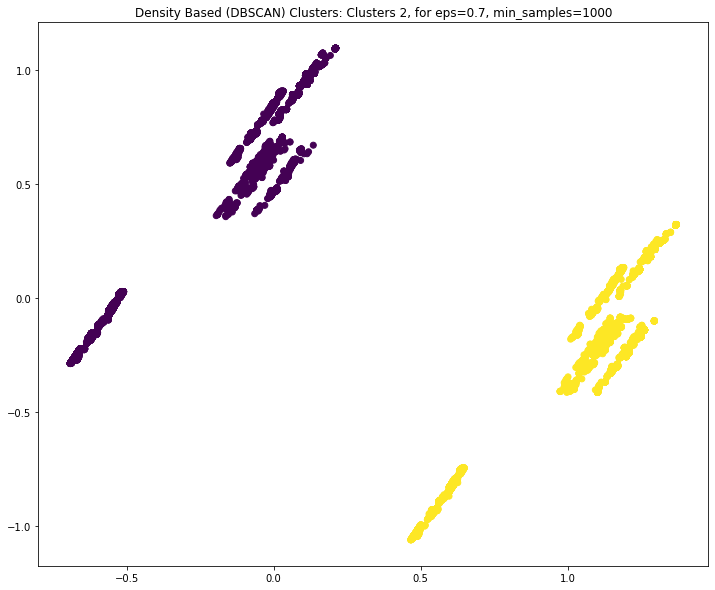

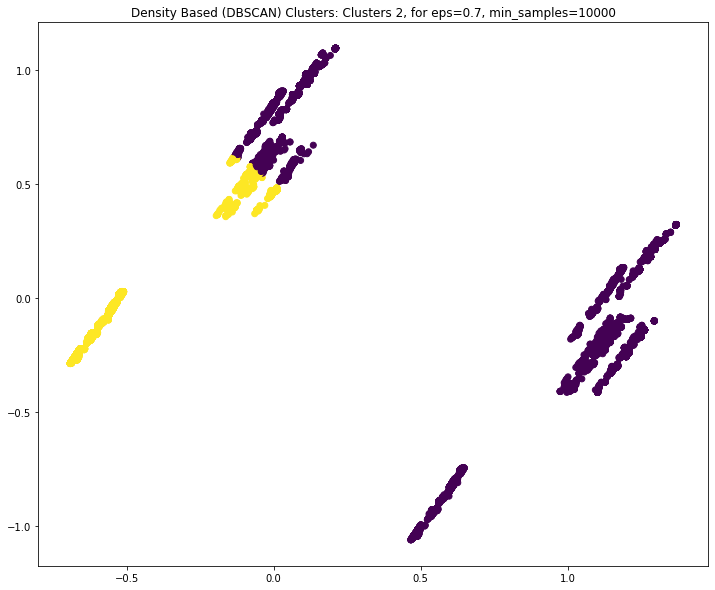

In [116]:
for dbscan_eps in [0.1, 0.3, 0.5, 0.7]:
    for dbscan_min_samples in [5, 50, 200, 1000, 10000]:
        
        dbscan = DBSCAN(eps = dbscan_eps, min_samples = dbscan_min_samples)\
                            .fit(property_sales_data_dummies_scaled_transformed_reduced)
        
        dbscan_clusters = dbscan.labels_

        dbscan_cluster_number = len(pd.Series(dbscan_clusters).unique().tolist())

        plot_clusters(property_sales_data_dummies_scaled_transformed_reduced, dbscan_clusters, 
              create_dbscan_diagram_title(dbscan_cluster_number, dbscan_eps, dbscan_min_samples))

As we could see, for too small (`0.1`) or too large (i.e. `0.5` or larger) values of $\epsilon$ the clustering is sub-optimal. For the rest of the cases, no matter what range the parameters of the DBSCAN algorithms are, it always identifies `4` clusters for our dataset.

We should note that opposite to the KMeans++ Clustering algorithm, DBSCAN behaves well with data which is not shaped in spherical/well-shaped clusters, so this gives us additional confidence that the optimal number of clusters for our dataset is `4`. 

## 5. Clustering Results: Analysis

Once we have identified that the most optimal number of clusters for our dataset is `4` we would like to analyse what are the corresponding characteristics of the sold properties in each of the clusters.

For the purpose, we are going to attempt analysing the data in each of the clusters from various standpoints, namely:

**Geographical Location**
This means that we will plot the clustered properties sales using their geographical coordinates to attempt understand visually whether geographical location of the properties is a significant factor in the clustering

**Word Cloud** 
As the clustering could be difined as a categorisation without category labels, we will try to generate word cloud for each cluster with the features of the sold properties which are statistically significant

**Pivot Plots**
Ultimately we will approach the clustered data using the pivot tables for the highly expressed features in order to find any rules of the way how the clusters are organised

### Auxilliary Functions for Clustering Analysis

#### Functions for Non-Visual Analysis

In [117]:
def clustered_samples(data, clusters):
    clustered_data = data
    clustered_data['cluster'] = clusters
    return clustered_data

In [118]:
def create_cluster_name(cluster, category):
    size = len(cluster[cluster.cluster == category])
    ratio = (size / len(cluster)) * 100
    title = "Cluster {} [size: {}, ratio: {:.2f}%]".format(category, size, ratio)
    return title

In [119]:
def print_cluster_info(cluster):
    categories = pd.Series(cluster.cluster).unique()
    for category in categories:
        print(create_cluster_name(cluster, category))

#### Functions for Geo-Plotting Clusters

In [120]:
def plot_clustered_properties_by_geo_location(data, title):
    """Plots clustered data using geo coordinates (without plotting the map itself). 
    The assumptions is that the number of records in the `property_sales_data` must match those in 
    `predicted_clusters`.
    
    Parameters:
    property_sales_data: Dataset which contains geo coordinates of sold properties
    predicted_clusters: The cluster type of a property
    title: Plot title
    """
    plt.figure(figsize = (12, 10))
    sns.scatterplot(data.lat, data.lon, hue = data.cluster, 
                palette = sns.color_palette('hls', np.unique(data.cluster).shape[0]))
    plt.title(title)
    plt.show()

In [121]:
def plot_clustered_properties_by_geo_location_in_separate_plot(data, feature_x_axis, feature_y_axis):
    sns.lmplot(feature_x_axis, feature_y_axis, data=data, hue="cluster", fit_reg = False, 
               col = 'cluster', col_wrap=2)

#### Functions for Statistical Labeling Clusters

In [122]:
def convert_clustered_samples_to_text(clustered_data):
    x = clustered_data.to_string(header=False,
                                 index=False,
                                 index_names=False,
                                 formatters={
                                     "ward": lambda x: "ward_{}".format(x),
                                     "neighborhood": lambda x: x.replace(" ", ""),
                                     "prop_type": lambda x: x.replace(" ", ""),
                                     "gross_sale_price": lambda x: "${:,.0f}grs_price".format(x),
                                     "position" : lambda point : "({:.2f},{:.2f})".format(point.x, point.y),
                                     # ignoring features below:
                                     "in_rto_study": lambda x: "",
                                     "cluster" : lambda x: "",
                                     "category": lambda x: "",
                                     "lat" : lambda x : "",
                                     "lon": lambda x: ""
                                 }).split('\n')
    lines = [' '.join(ele.split()) for ele in x]
    text = " ".join(line for line in lines)
    return text

In [123]:
def create_wordcloud(text):
    stopwords = set(STOPWORDS)
    stopwords.update(['hbhd', 'ward', 'lat', 'lon', 'POINT'])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", \
                          collocations = False, max_font_size=40,
                          max_words=30).generate(text)
    # print(wordcloud.words_)
    return wordcloud

In [124]:
def plot_wordcloud(wordcloud, title):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

In [125]:
def plot_wordcloud_for_clusters(data):   
    clusters = pd.Series(data.cluster).unique()
    for cluster in clusters:
        cluster_title = create_cluster_name(data, cluster)
        text = convert_clustered_samples_to_text(data)
        wordcloud = create_wordcloud(text)
        plot_wordcloud(wordcloud, cluster_title)

In [126]:
def plot_geolocation_and_wordcloud_for_clusters(data, title):  
    clusters = pd.Series(data.cluster).unique()
    clusters_number = len(clusters)
    diagrams_number = 2

    fig = plt.figure(figsize=(30,45))
    plot_index = 1
    plt.title(title, fontsize=25, fontweight='bold', pad=20)
    plt.axis("off")
    
    for cluster_number in range(1,clusters_number+1):
        cluster_index = cluster_number - 1
        clustered_samples = data[data.cluster == cluster_index]
        cluster = data[data.cluster == cluster_index].cluster
        
        cluster_title = create_cluster_name(data, cluster_index)
        
        axisId1 = clusters_number*100 + diagrams_number*10 + plot_index
        plot_index = plot_index + 1
        ax1 = fig.add_subplot(axisId1)
  
        colour = cm.nipy_spectral(float(cluster_index) / clusters_number)
        sns.scatterplot(clustered_samples.lat, clustered_samples.lon, hue = cluster, 
                        ax=ax1, facecolor= colour, edgecolor=colour, alpha=0.7)
        ax1.set_title(cluster_title, fontsize=14, fontweight='bold')
        
        axisId2 = clusters_number*100 + diagrams_number*10 + plot_index
        plot_index = plot_index + 1
        
        ax2 = fig.add_subplot(axisId2)
        
        # print("Cluster: {}".format(cluster_index))
        text = convert_clustered_samples_to_text(clustered_samples)
        wordcloud = create_wordcloud(text)
        ax2.imshow(wordcloud, interpolation='bilinear')
        ax2.axis("off")

#### Functions for Pivot Plots

In [127]:
def pivot_plot(clustered_data, index_feature, x_label, fig_size_x, fig_size_y):
    sns.set(rc={'figure.figsize':(fig_size_x,fig_size_y)})
    pd.pivot_table(clustered_data, 
                   index = [index_feature], 
                   columns= 'cluster', 
                   values=['gross_sale_price'],
                   fill_value= 0,
                   aggfunc=np.sum)\
        .plot(kind='bar')

    plt.xlabel(x_label)
    plt.ylabel('Gross Sale Price')
    plt.title('Pivot Plot: Cluster Gross Price Comparison by '+ x_label)

In [128]:
def default_sized_pivot_plot(clustered_data, index_feature, x_label):
    fig_size_x = 20
    fig_size_y = 10
    pivot_plot(clustered_data, index_feature, x_label, fig_size_x, fig_size_y)

In [129]:
def pivot_plot_aggregated_data(data, aggregation):
    sns.set(rc={'figure.figsize':(10,5)})
    pivot_table = pd.pivot_table(data, 
                                index = ['cluster'], 
                               columns= 'cluster', 
                               values=['total'],
                               fill_value= 0)\
                    .plot(kind='bar')

    plt.xlabel('Cluster')
    plt.ylabel('{} Gross Sale Price ($)'.format(aggregation))
    plt.title('Pivot Plot: Cluster Gross Price Comparison by {} Gross Price'.format(aggregation))

### Cluster Generation

We will generate clusters using each of the algorithms explored above, so that we could analyse their output in the next section.

#### KMeans++ Clustering: 4 Clusters

In [130]:
kmeans_clusterer_4_clusters = KMeans(n_clusters = 4)
kmeans_clusterer_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)
kmeans_4_clusters = kmeans_clusterer_4_clusters.predict(property_sales_data_dummies_scaled_transformed_reduced)

#### Agglomerative Clusterring: 4 Clusters

In [131]:
agglomerative_clusterer_4_clusters = AgglomerativeClustering(n_clusters=4)
agglomerative_clusterer_4_clusters.fit(property_sales_data_dummies_scaled_transformed_reduced)
agglomerative_4_clusters = agglomerative_clusterer_4_clusters.labels_

#### DBSCAN Clustering: 4 Clusters (eps = 0.3, min_samples = 200)

In [132]:
dbscan_clusterer_4_clusters = DBSCAN(eps=0.3, min_samples=200).fit(property_sales_data_dummies_scaled_transformed_reduced)
dbscan_4_clusters = dbscan_clusterer_4_clusters.labels_

### Enhance Sales Data With Cluster Information

Before continuing our analysis let us add the found cluster numbers/labels to our `property_sales_data` to help the analysis.

In [133]:
clustered_property_sales_data_kmeans = clustered_samples(property_sales_data, kmeans_4_clusters)

In [134]:
clustered_property_sales_data_aggl = clustered_samples(property_sales_data, agglomerative_4_clusters)

In [135]:
clustered_property_sales_data_dbscan = clustered_samples(property_sales_data, dbscan_4_clusters)

### Clustering Results: Analysis by Cluster Sizes and Cluster Identity

Let review what are the sizes of the clusters generated by each of the algorithms.

In [136]:
print_cluster_info(clustered_property_sales_data_kmeans)

Cluster 0 [size: 4204, ratio: 20.46%]
Cluster 1 [size: 4267, ratio: 20.76%]
Cluster 2 [size: 10252, ratio: 49.89%]
Cluster 3 [size: 1827, ratio: 8.89%]


In [137]:
print_cluster_info(clustered_property_sales_data_aggl)

Cluster 0 [size: 4204, ratio: 20.46%]
Cluster 1 [size: 4267, ratio: 20.76%]
Cluster 2 [size: 10252, ratio: 49.89%]
Cluster 3 [size: 1827, ratio: 8.89%]


In [138]:
print_cluster_info(clustered_property_sales_data_dbscan)

Cluster 0 [size: 4204, ratio: 20.46%]
Cluster 1 [size: 4267, ratio: 20.76%]
Cluster 2 [size: 10252, ratio: 49.89%]
Cluster 3 [size: 1827, ratio: 8.89%]


Apparently, perhaps due to the structure of the data (i.e. well defined groups without overlapping), the sizes of the clusters produced by each of the algorithms are the same.

In [139]:
np.array_equal(clustered_property_sales_data_kmeans['cluster'].tolist(), 
               clustered_property_sales_data_aggl['cluster'].tolist())

True

In [140]:
np.array_equal(clustered_property_sales_data_kmeans['cluster'].tolist(), 
               clustered_property_sales_data_dbscan['cluster'].tolist())

True

We could conclude that the **clusters identified by each of the algorithms** are **identical**, hence we could do the further analysis using the results generated by just one of the algorithms.

For the rest of the sections, unless stated otherwise, we will use the KMeans++ clustering results for generalising our conclusions for the properties sales data.

### Clustering Results: Analysis by Geographical Location

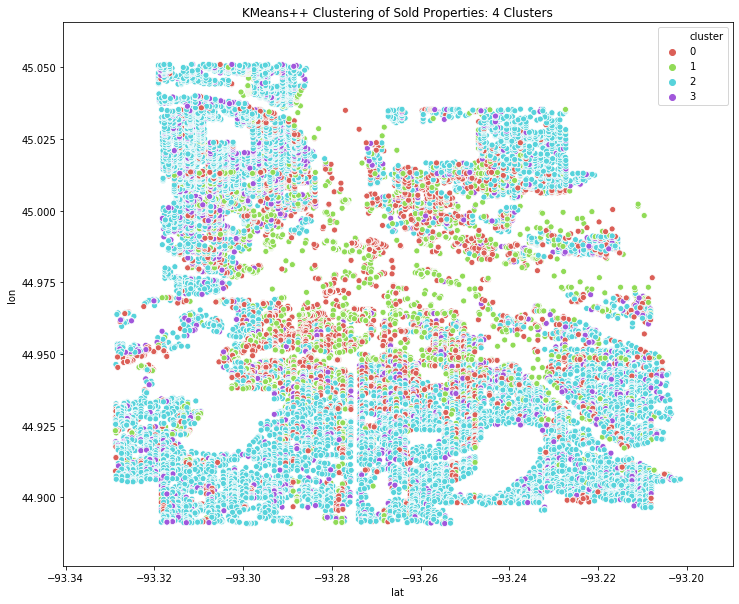

In [141]:
plot_clustered_properties_by_geo_location(clustered_property_sales_data_kmeans, 
                                          "KMeans++ Clustering of Sold Properties: 4 Clusters")

Apparently overlaying all clusters on the same map does not give us very clear idea how strongly the geographical distribution of the properties influences the clusters structure. There is partial clarity on the presence of properties from cluster `0` and `1` in the central part of the city, while properties from clusters `2` and `3` are rather in the outscirts, but it is hard to read.

We will geographically plot the clusters each on its own and try to eventually find any relation:

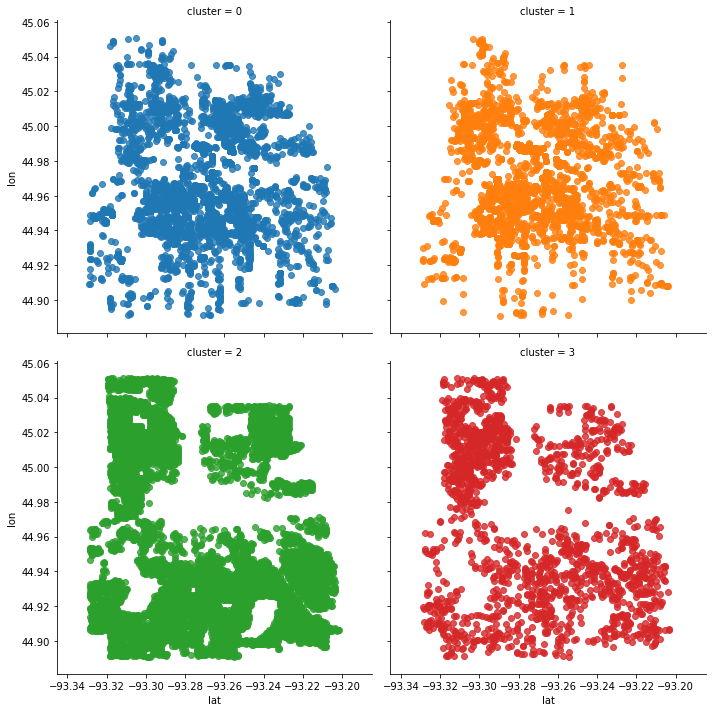

In [142]:
plot_clustered_properties_by_geo_location_in_separate_plot(clustered_property_sales_data_kmeans, 'lat', 'lon')

We could see that **geography** has **partial impact on the cluster structure**. 

Our observations are as follows:
* Cluster `0` and `1` are:
    * similar in shape
    * have clear presence in the **central parts of the city**
* Cluster `2` and `3` 
    * are similar in shape
    * have clear presence in the **periphery of the city**

### Clustering Results: Analysis by Statistical Labeling

One approach to analyse the clustered data is to convert its feautres to text and analyse statistically which are the most frequent words/strings met in the text for each cluster. 

The auxilliary function we have defined above `convert_clustered_samples_to_text(...)` does exactly that, as the features which are not defining the properties in a cluster such as `in_rto_study`, `latitude` and `longitude` are excluded, and those which are used are the following:
* `ward`
* `neighborhood`
* `prop_type`
* `gross_sale_price`

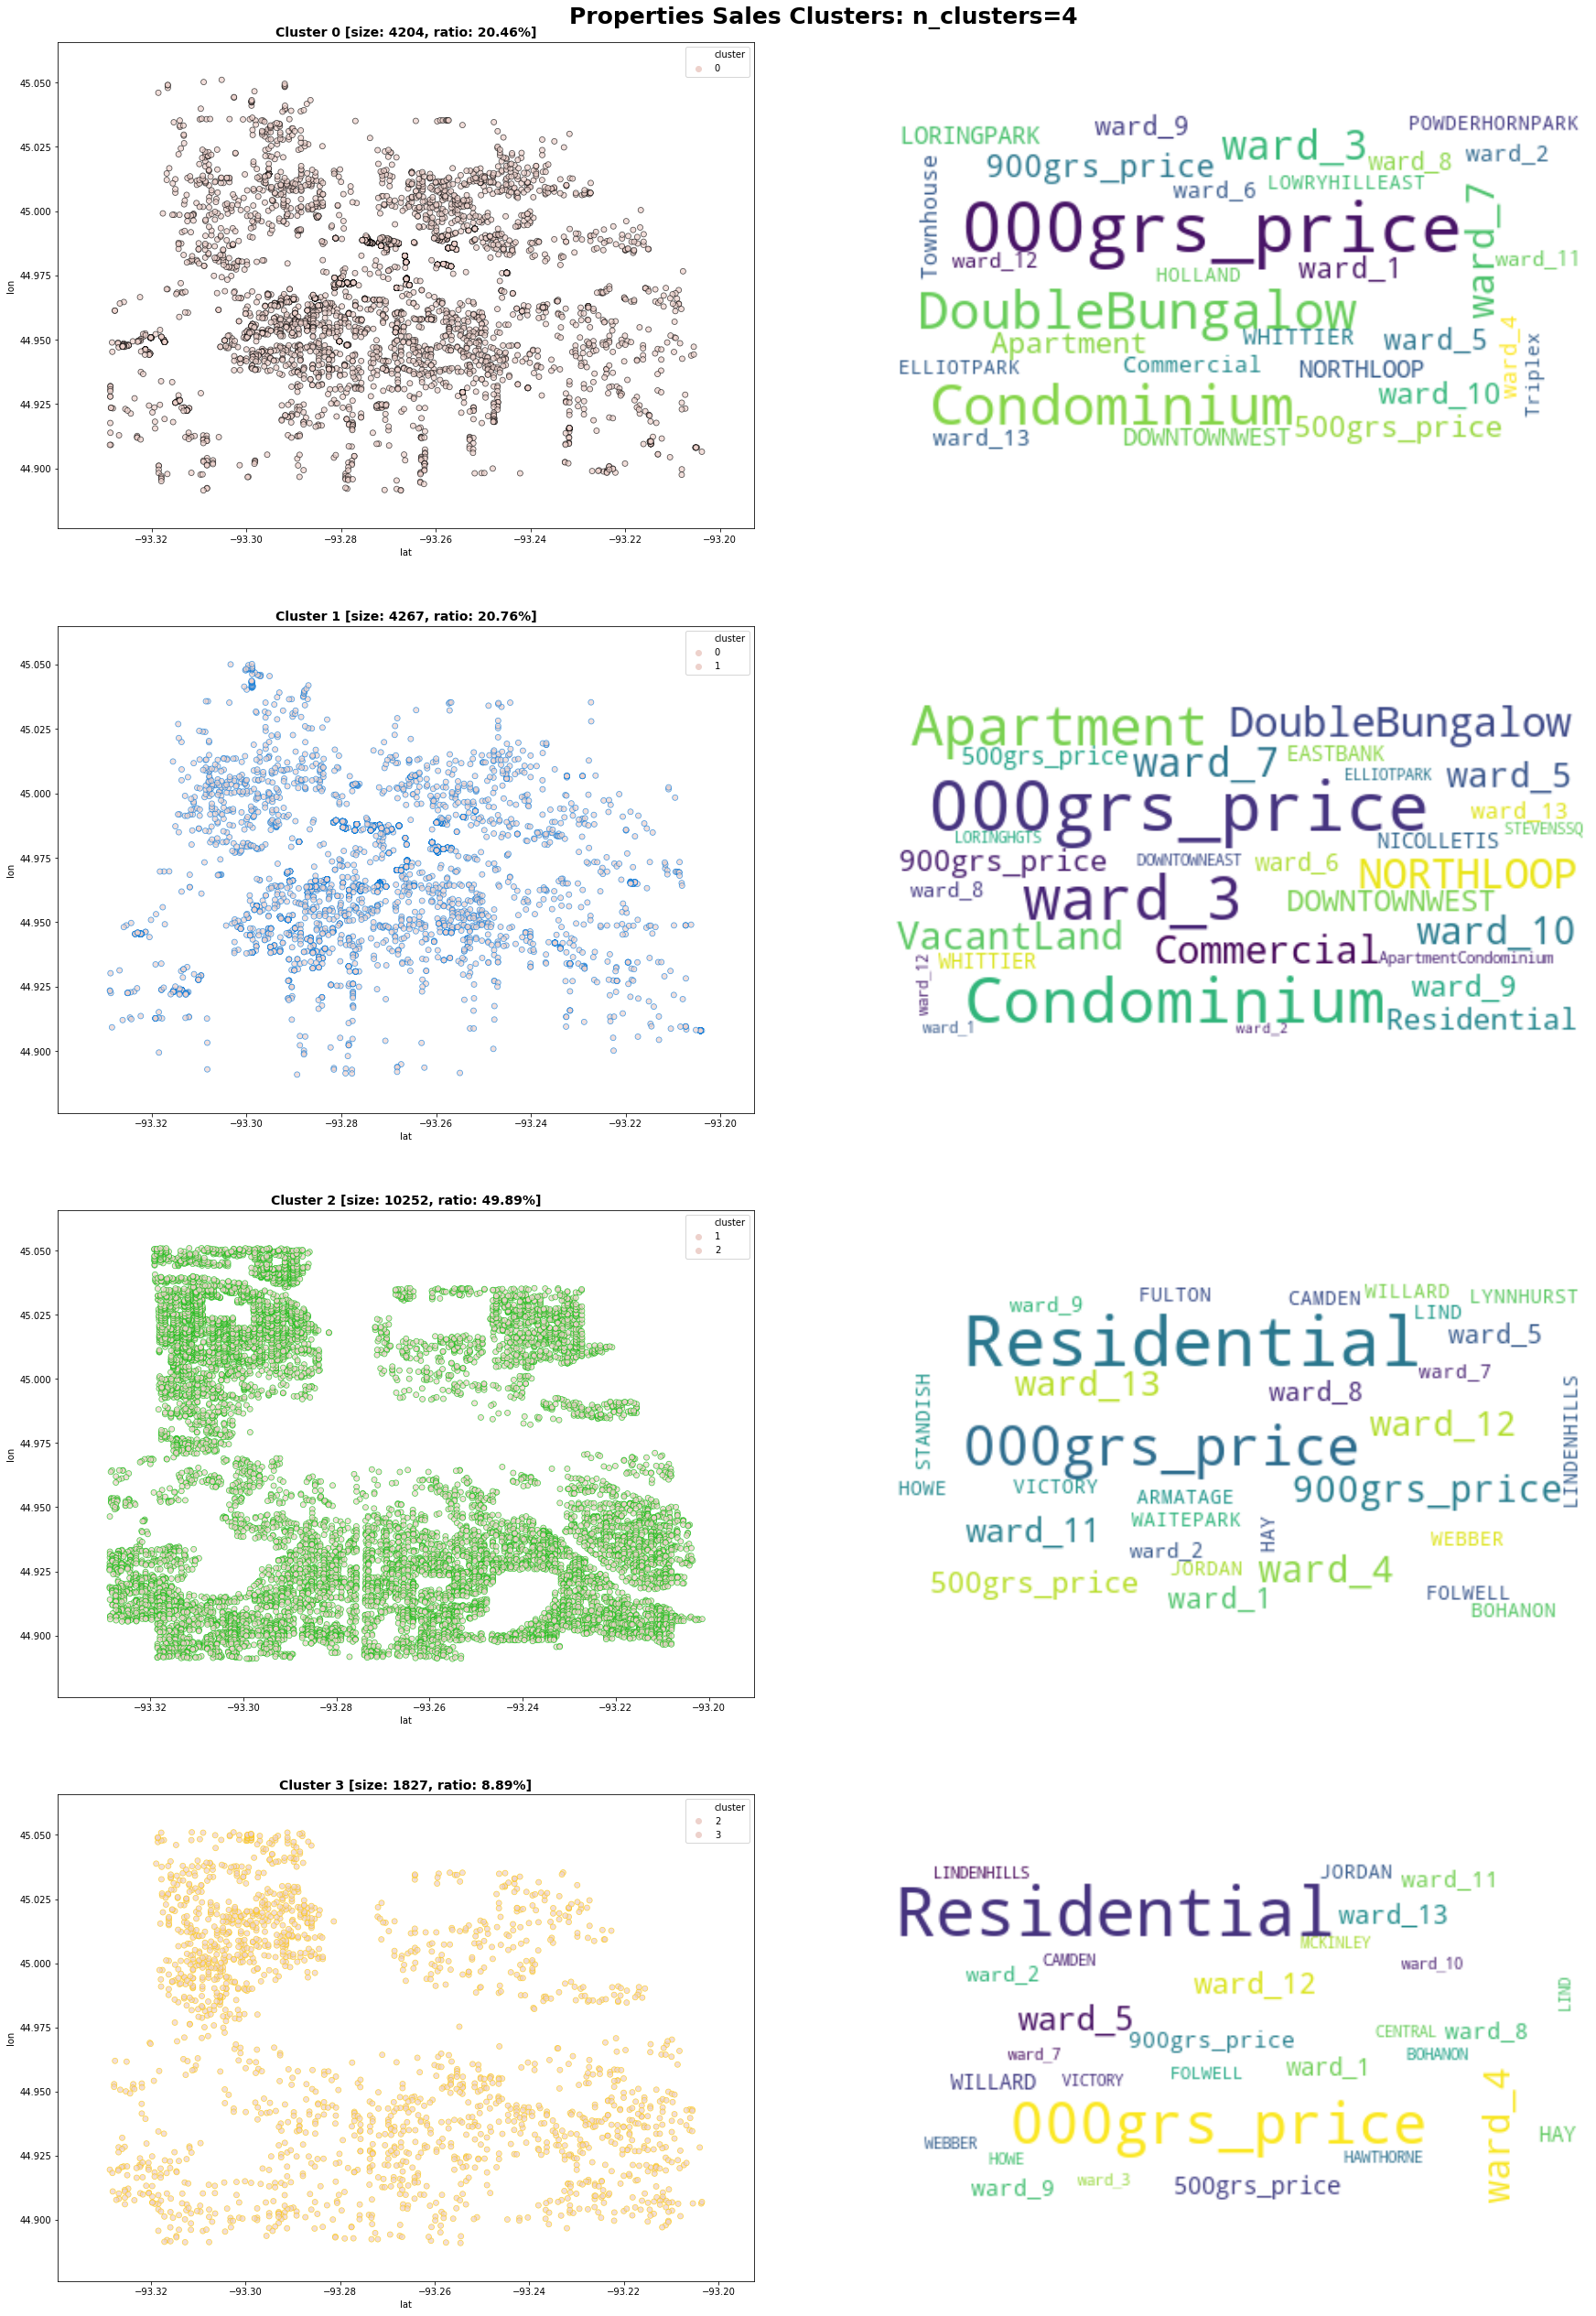

In [143]:
plot_geolocation_and_wordcloud_for_clusters(clustered_property_sales_data_kmeans, 
                                            "Properties Sales Clusters: n_clusters=4")

If we have to convert word clouds above into a tabular format, the data would look like the one below (please note that the order in the sells is important - top values are most frequent while the bottom ones - less):
```
                            Statistically Defined Cluster Labels
┌───────────────┬─────────────────┬───────────────────────┬─────────────┬─────────────┐
│    Feature    │   Cluster: 0    │       Cluster 1       │  Cluster 2  │  Cluster 3  │
├───────────────┼─────────────────┼───────────────────────┼─────────────┼─────────────┤
│ Gross Price   │ $0              │ $0                    │ $0          │ $0          │
│               │ $900,000        │ $900,000              │ $900,000    │ $500,000    │
│               │ $500,000        │ $500,000              │ $500,000    │ $900,000    │
├───────────────┼─────────────────┼───────────────────────┼─────────────┼─────────────┤
│ Property Type │ Condominium     │ Condominium           │ Residential │ Residential │
│               │ Double Bungalow │ Apartment             │             │             │
│               │ Apartment       │ Double Bungalow       │             │             │
│               │ Townhouse       │ Commercial            │             │             │
│               │ Commercial      │ VacantLand            │             │             │
│               │ Triplex         │ Residential           │             │             │
│               │                 │ Apartment Condominium │             │             │
├───────────────┼─────────────────┼───────────────────────┼─────────────┼─────────────┤
│ Ward          │ Ward 3          │ Ward 3                │ Ward 4      │ Ward 4      │
│               │ Ward 7          │ Ward 7                │ Ward 12     │ Ward 5      │
│               │ Ward 10         │ Ward 10               │ Ward 13     │ Ward 12     │
│               │ Ward 1          │ Ward 5                │ Ward 11     │ Ward 13     │
│               │ Ward 5          │ Ward 9                │ Ward 1      │ Ward 1      │
│               │ Ward 9          │ Ward 6                │ Ward 8      │ Ward 9      │
│               │ Ward 8          │ Ward 13               │ Ward 5      │ Ward 8      │
│               │ Ward 2          │ Ward 8                │ Ward 2      │ Ward 11     │
│               │ Ward 13         │ Ward 12               │ Ward 9      │ Ward 2      │
│               │ Ward 4          │ Ward 1                │ Ward 7      │ Ward 3      │
│               │ Ward 6          │ Ward 2                │             │ Ward 7      │
│               │ Ward 12         │                       │             │ Ward 10     │
│               │ Ward 11         │                       │             │             │
├───────────────┼─────────────────┼───────────────────────┼─────────────┼─────────────┤
│ Neighbourhood │ NORTHLOOP       │ NORTHLOOP             │ FULTON      │ WILLARD     │
│               │ DOWNTOWNWEST    │ DOWNTOWNWEST          │ STANDISH    │ HAY         │
│               │ LORINGPARK      │ NICOLLETIS            │ VICTORY     │ JORDAN      │
│               │ WHITTIER        │ EASTBANK              │ WILLARD     │ FOLWELL     │
│               │ ELLIOTPARK      │ WHITTIER              │ HAY         │ HOWE        │
│               │ POWDERHORNPARK  │ STEVENSSQ             │ JORDAN      │ HAWTHORNE   │
│               │ HOLLAND         │ LORINGHGTS            │ HOWE        │ VICTORY     │
│               │ LOWRYHILLEAST   │ ELLIOTPARK            │ LINDENHILLS │ LIND        │
│               │                 │ DOWNTOWNEAST          │ FOLWELL     │ BOHANON     │
│               │                 │                       │ WAITEPARK   │ WEBBER      │
│               │                 │                       │ LIND        │ CAMDEN      │
│               │                 │                       │ BOHANON     │ MCKINLEY    │
│               │                 │                       │ ARMATAGE    │ CENTRAL     │
│               │                 │                       │ WEBBER      │ LINDENHILLS │
│               │                 │                       │ CAMDEN      │             │
│               │                 │                       │ LYNNHURST   │             │
└───────────────┴─────────────────┴───────────────────────┴─────────────┴─────────────┘
```

#### Gross Price
We could conclude that due to the small changes in each of the **property sale prices**, this feature **could not be used in statistical labeling** in its **raw form**. It needs to be pre-processed and replaced by price ranges first.

#### Property Type
There is a clear distinction between the property types of the different clusters:
* **clusters `0` and `1`** are having **higher class properties**:
    * `Condominium`s
    * `Double Bungalow`s and `Apartment`s
    * as well as `Compertial` properties
* **clusters `2` and `3`** are having **`Residential`** type properties only

#### Ward

<div>
    <span style="font-style:italic;">Minneapolis City Council Wards</span>
    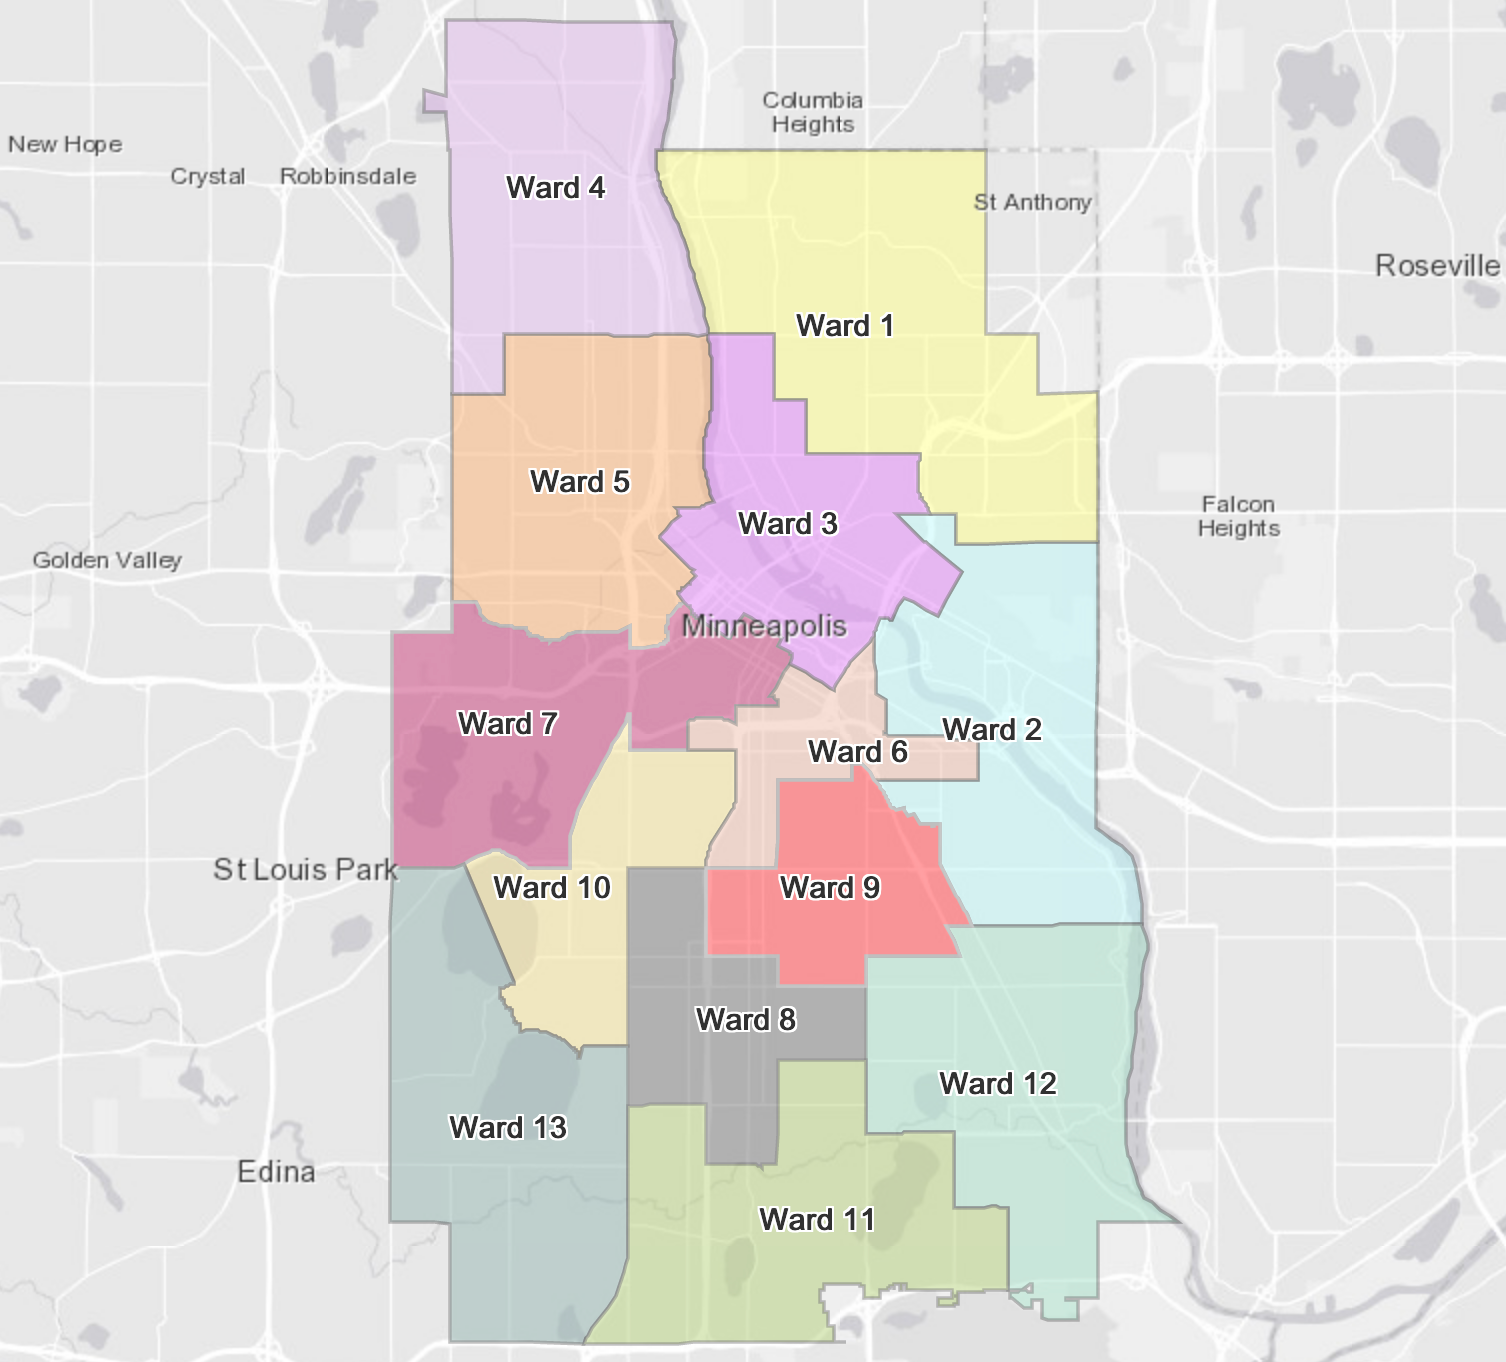
</div>

Ward-wise, we could identify the clear rule which we observed in the geo-location analysis, that:
* **cluster `0` and `1` overlap** in their core wards, i.e.:
    * the majority of the properties belonging to these clusters share the same wards:
        * `Ward 3`
        * `Ward 7` 
        * `Ward 10`
        * `Ward 1` and `Ward 5`
* **cluster `2` and `3` overlap** in their core wards, i.e.:
    * the majority of the properties belonging to these clusters share the same wards:
        * `Ward 4`
        * `Ward 5` 
        * `Ward 12`
        * `Ward 13`
        * `Ward 1`
        * `Ward 8` and `Ward 9`
* clusters `0` and `1` **do not overlap** with clusters `2` and `3` in their core wards

#### Neighbourhood


<div>
    <span style="font-style:italic;">Minneapolis City Council Neighbourhoods</span>
    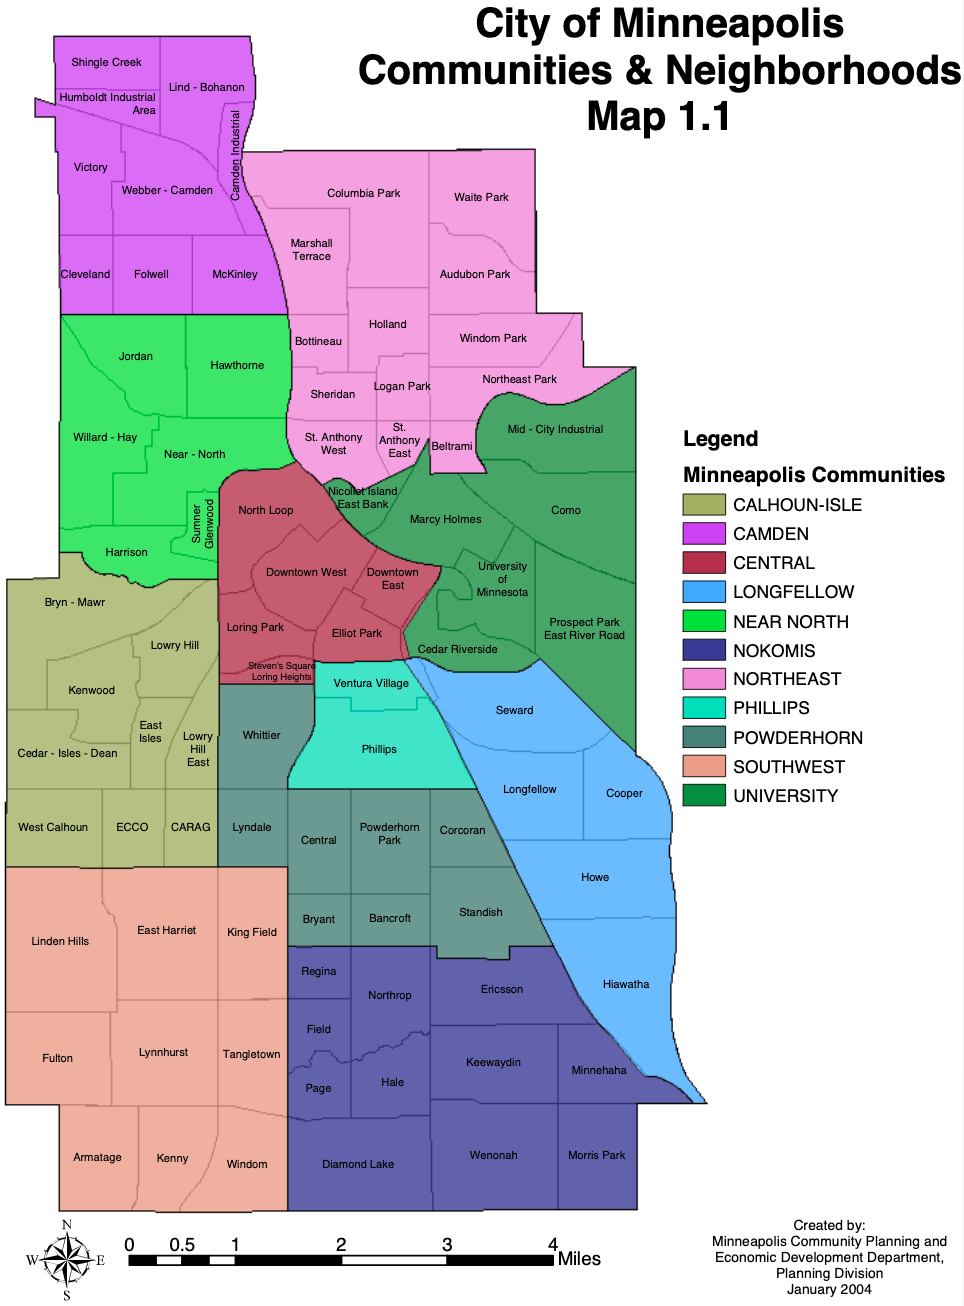
</div>

Regarding neighbourhoods, the overlap is not fully replicated from the wards:
* **cluster `0` and `1` overlap** in their core neighbo:
    * the majority of the properties belonging to these clusters share the same wards:
        * `NORTHLOOP`
        * `DOWNTOWNWEST` 
* **cluster `2` and `3` overlap** in their core wards, i.e.:
    * the majority of the properties belonging to these clusters share the same wards:
        * `Ward 4`
        * `Ward 5` 
        * `Ward 12`
        * `Ward 13`
        * `Ward 1`
        * `Ward 8` and `Ward 9`
* clusters `0` and `1` **do not overlap** with clusters `2` and `3` in their core wards

### Clustering Results: Analysis by Pivot Tables

In this sub-section we will try to find some rules which define the various clusters as for a tool we will use pivot plots to visualise the property gross pricess in relation to several features.

The features for which we would like to analyse the property gross price per cluster are subset of the properties considered in the labeled statistical analysis:
* Property Type
* Ward
* Neighbourhood

Please note that the mean is used for rendering the prices in order to compact the graphics.

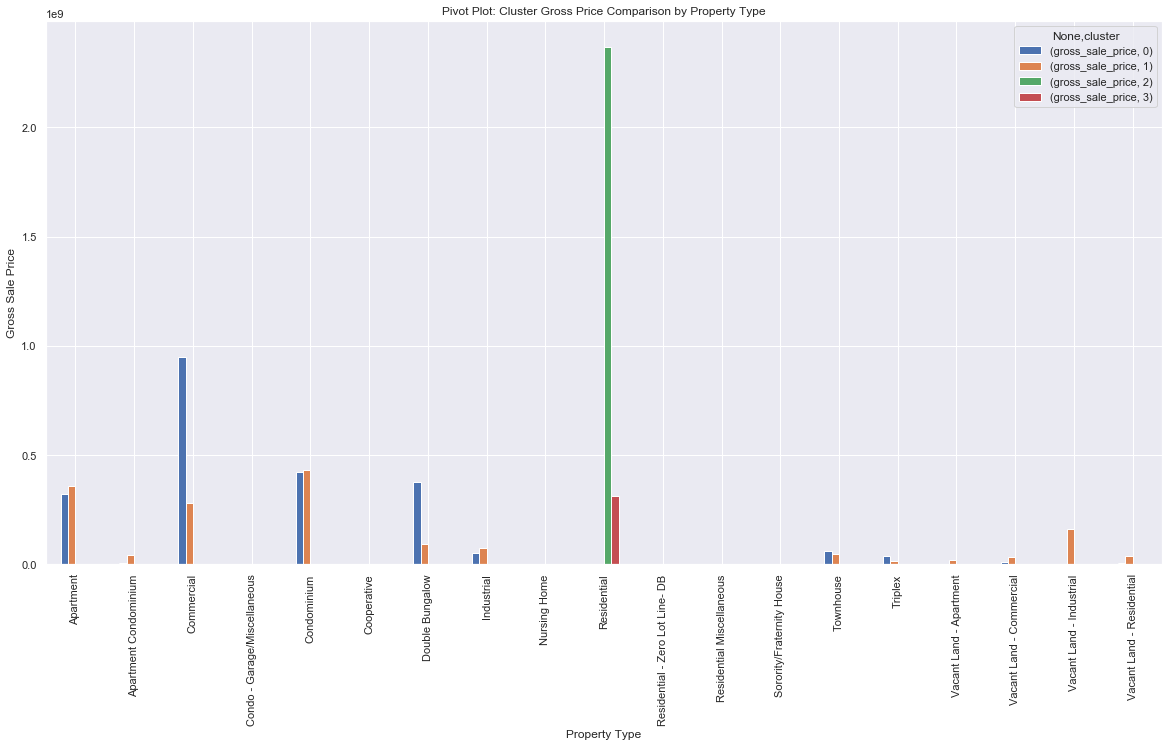

In [144]:
default_sized_pivot_plot(clustered_property_sales_data_kmeans, 'prop_type', 'Property Type')

Based on the total gross sale price of properties per property type, there is clear distinction of:
* cluster `0` consists of high-end properties - `Comercial`, `Apartment`, `Condominium` and `Double Bungalow`
* cluster `1` is characterised by properties mostly of type `Condominium`, `Apartment`, `Comercial`, `Vacant Land - Industrial` and less of types `Double Bungalow` and `Industrial` properties
* cluster `2` is highly represented by properties of type `Residential`
* cluster `3` is as well `Residential` properties but of lower price and quantity

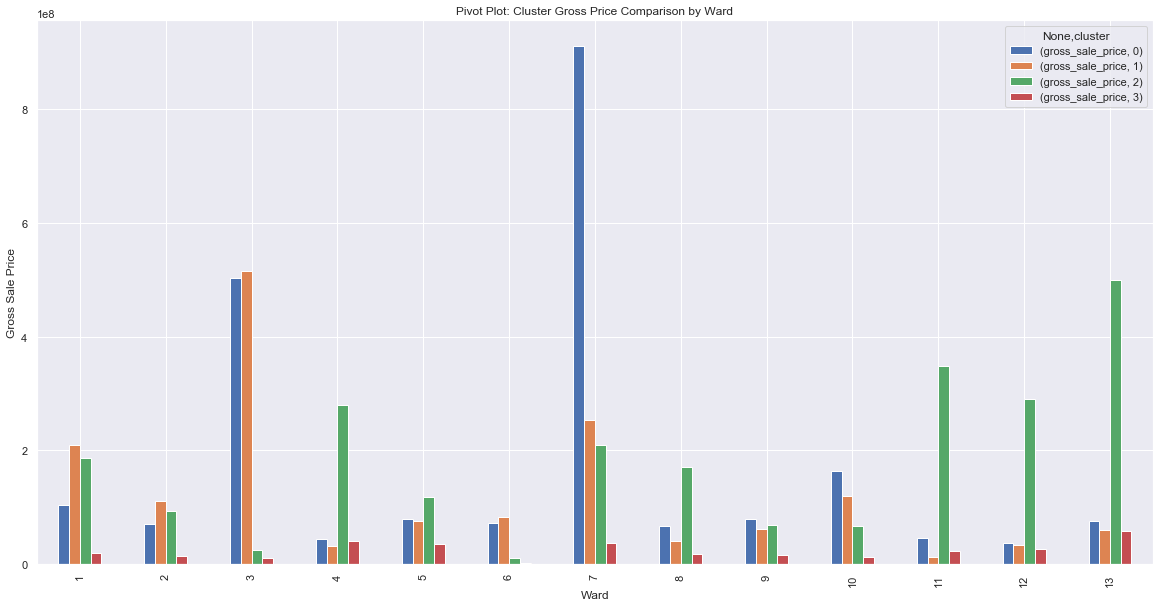

In [145]:
default_sized_pivot_plot(clustered_property_sales_data_kmeans, 'ward', 'Ward')

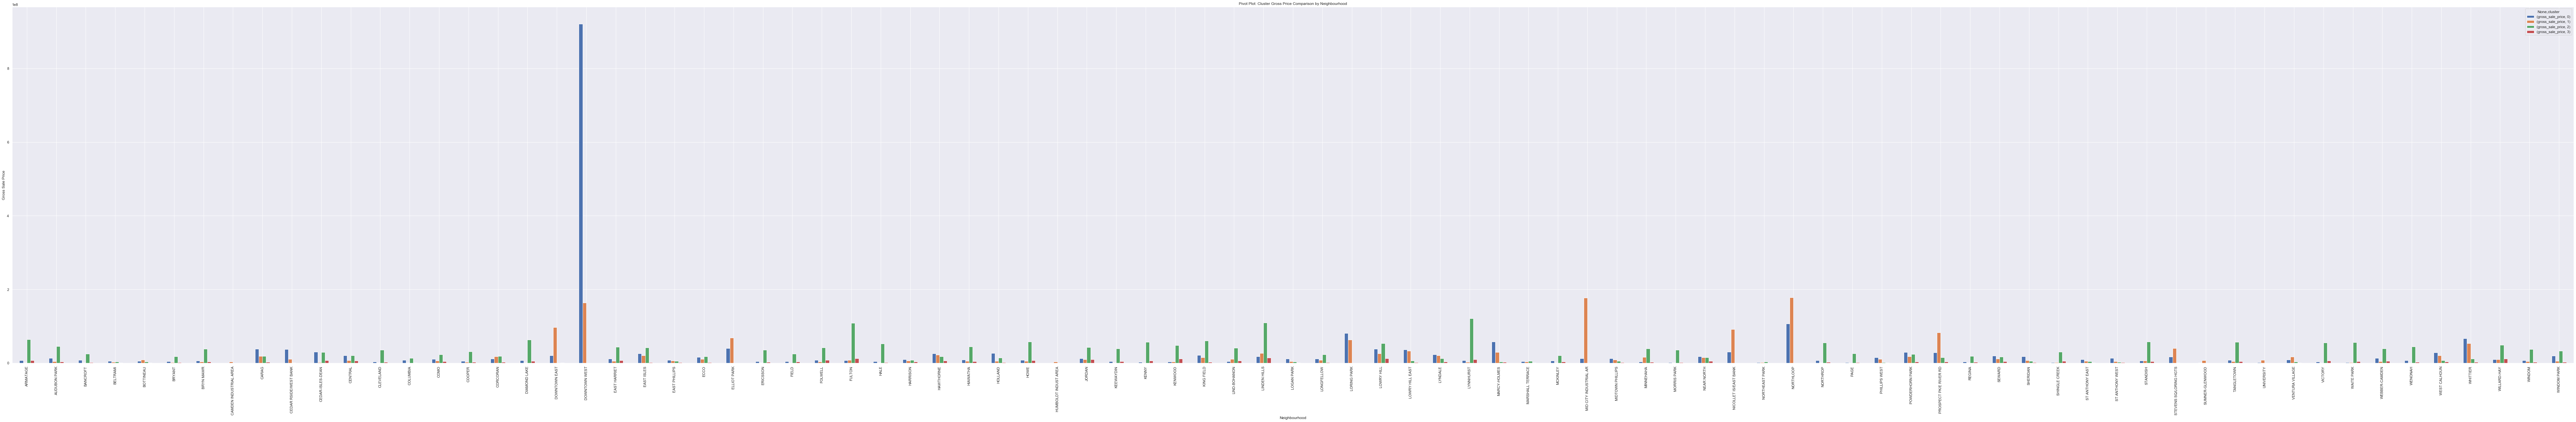

In [146]:
fig_size_x = 140
fig_size_y = 20

pivot_plot(clustered_property_sales_data_kmeans, 'neighborhood', 'Neighbourhood', fig_size_x, fig_size_y)

The price band of clusters `0` and `1` in general higher than the one of clusters `3` and `4`, as there are some outliers in each the clusters. 

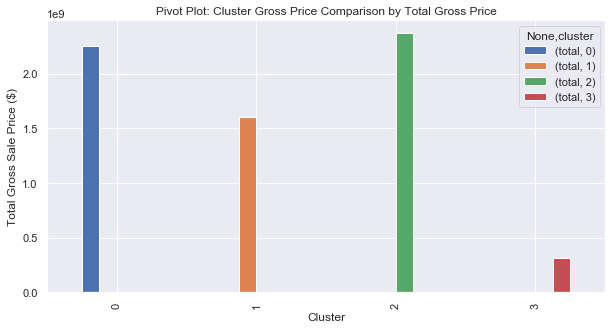

In [147]:
gross_price_sum = clustered_property_sales_data_kmeans.groupby('cluster')\
                    .gross_sale_price.sum()\
                    .reset_index(name='total')

pivot_plot_aggregated_data(gross_price_sum, 'Total')

Because of the amount of the sold residential properties in cluster `2` its share of the market is high (`49.89%`) hence the total amount (in terms of gross price) is highest, followed by cluster `1` and `0`.

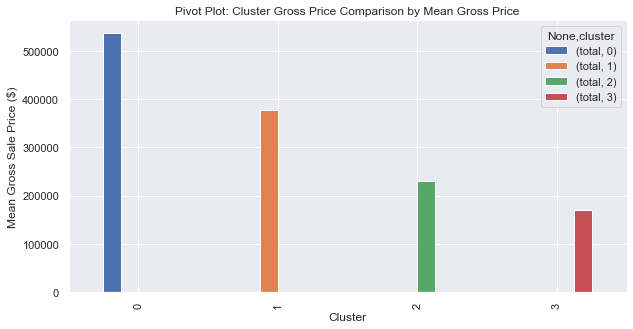

In [148]:
gross_price_mean = clustered_property_sales_data_kmeans.groupby('cluster')\
                    .gross_sale_price.mean()\
                    .reset_index(name='total')

pivot_plot_aggregated_data(gross_price_mean, 'Mean')

The highest end properties in terms of gross sale price are in cluster `0` and `1`.

## 6. Conclusions

We can conclude that the properties sales market in Minneapolis for the period of 2002-2005 is shaped by two main factors - location and property types as the four main types of properties could be organised in four main groups/clusters:
* **Comercial and High-end Living Properties** 
    * Cluster `0`
    * 20.46% of the market
    * Consisting of Comercial Spaces, Apartments, Condominiums and Double Bungalows
    * located mostly in the city centre and the outskirts of the city:
        * Wards: 3, 7, 10, 1
        * Neighbourhoods: Northloop, Downtown-West, Loring Park, Whittier
* **High-end Living Properties with some Comercial Properties and Industrial Land** 
    * Cluster `1`
    * 20.76% market share
    * Consisting of Condominiums, Apartments, Comercial Properties, Industrial Vacant Land and Industrial Properties
    * Similarly to the previous group the properties in this one are located mostly in the city centre and the outskirts of the city:
        * Wards: 3, 7, 10, 5
        * Neighbourhoods: Northloop, Downtown-West, Nicolletis, Eeast Bank 
* **Residential Properties** 
    * Cluster `2`
    * 49.89% - highest market share
    * Consisting mostly of Residential Properties
    * The location of these properties are mostly out of the central part of the city:
        * Wards: 4, 12, 13, 11, 1
        * Neighbourhoods: Fulton, Standish, Victory, Willard, Hay
* **Low-end Residential Properties** 
    * Cluster `3`
    * 8.89% - highest market share
    * Consisting mostly of low-end Residential Properties       
    * The location of these properties are mostly out of the central part of the city:        
        * Wards: 4, 5, 12, 13, 1
        * Neighbourhoods: Willard, Hay, Jordan, Folwell, Howe

Future buyers and investors could use this data to make informed decisions and navigate on the property market of Minneapolis.

## 7. Future Work

After the course exam some deficiencies of this work were pointed out which need to be addressed accordinlgy before developing it further:
* Reducing the number of samples from `~70,000` to `~20,000` does not influence the clustering, as the duplicated samples would just project to the same cluster points later on.
* PCA is not really needed for the clustering and the original set of features seem to be sufficient
* Even if PCA is used, currently it uses just around `30%` of the new parameters which matter (ideally the aim should be to use at least `90%`). Please see `pca.explained_variance_ratio_` above
* KMeans Clustering is not really applicable to this use case as the clusters discovered do not seem to be spherical, while KMeans need spherically distributed data
* Looking at the silhouette profiles it is clearly visible that the clusters are not very similar in terms of shape and size hence, further exploration would need to be done, e.g. 
    * need to be verified how the silhouette profiles of 11 or 12 clusters look like
* In order to improve the time for calculating the dendrograms, we could reduce the dept of the trees

Once the main points above are addressed, this analysis could be extended further, as the main directions work could be done are as follows:
* Generalising the analysis for newer data sets (e.g. 2010-2013)
* Pre-processing the gross price of properties into price bands in order to be leverage statistically labeling as well as to add it to as characteristics of the property clusters/groups
* Automating the data analysis and pre-processing using Pandas Pipelines
* Unifying the colours of the clusters across the Jupiter Notebook
* Render ward and neighbourhood names on the map/cluster plots

## References

1. [Property Sales 2002-2005, Minneapolis, Minnesota, USA](https://data.world/minneapolismn/342cfcca2eae40838adf5602299dfcd4-0)
2. [Open Minneapolis, Property Sales 2002-2005](http://opendata.minneapolismn.gov/datasets/342cfcca2eae40838adf5602299dfcd4_0)
3. [Minneapolis City Council Wards](https://www.arcgis.com/home/item.html?id=0e9be43abc834e85bc6ad003d9358c76)
4. [City of Minneapolis Communities & Neighbourhoods Map](http://www.minneapolismn.gov/www/groups/public/@cped/documents/maps/convert_273414.pdf)